In [1]:
!git clone https://github.com/Trung-Nam-2512/analysis-heatmap.git
%cd analysis-heatmap

!pip install -r requirements.txt

!ls


Cloning into 'analysis-heatmap'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 37 (delta 6), reused 34 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (37/37), 11.04 MiB | 13.72 MiB/s, done.
Resolving deltas: 100% (6/6), done.
/content/analysis-heatmap
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 9.1 MB/s eta 0:00:00
  

In [2]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Thiết lập style cho biểu đồ
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
# Đường dẫn file Excel
excel_file = '4_stations_31_7.xlsx'

# Kiểm tra file có tồn tại không
import os
if os.path.exists(excel_file):
    print(f"✅ File {excel_file} tồn tại!")
else:
    print(f"❌ File {excel_file} không tồn tại!")
    print("Hãy đảm bảo file Excel nằm trong cùng thư mục với notebook này.")
print("✅ Đã import thành công tất cả thư viện!")

✅ File 4_stations_31_7.xlsx tồn tại!
✅ Đã import thành công tất cả thư viện!


In [3]:
# Đọc thông tin các sheet trong file Excel
xls = pd.ExcelFile(excel_file)
sheet_names = xls.sheet_names

print(f"📊 Thông tin file Excel:")
print(f"• Tên file: {excel_file}")
print(f"• Số trạm: {len(sheet_names)}")
print(f"• Tên các trạm: {sheet_names}")

# Hiển thị thông tin từng sheet
for i, sheet in enumerate(sheet_names, 1):
    df_temp = pd.read_excel(excel_file, sheet_name=sheet)
    print(f"\n{i}. Trạm {sheet}:")
    print(f"   • Số dòng: {len(df_temp)}")
    print(f"   • Số cột: {len(df_temp.columns)}")
    print(f"   • Các cột: {list(df_temp.columns)}")

📊 Thông tin file Excel:
• Tên file: 4_stations_31_7.xlsx
• Số trạm: 4
• Tên các trạm: ['Bienhoa', 'Nhabe', 'Phuan', 'Thudaumot']

1. Trạm Bienhoa:
   • Số dòng: 12418
   • Số cột: 19
   • Các cột: ['ID', 'Times', 'ID.1', 'water level', 'rainfall', 'LSL', 'Built-up', 'Ups_discharge (Trian)', 'Year', 'Unnamed: 9', 'Decustering ID', 'Times.1', 'water level.1', 'rainfall.1', 'LSL.1', 'Built-up.1', 'Ups_discharge (Trian).1', 'Unnamed: 17', '>=1.6']

2. Trạm Nhabe:
   • Số dòng: 12418
   • Số cột: 19
   • Các cột: ['ID', 'Times', 'ID.1', 'water level', 'rainfall', 'LSL', 'Built-up', 'Ups_discharge (Trian)', 'Ups_discharge (Dautieng)', 'Unnamed: 9', 'Unnamed: 10', 'Decustering ID', 'Times.1', 'water level.1', 'rainfall.1', 'LSL.1', 'Built-up.1', 'Ups_discharge (Trian).1', 'Ups_discharge (Dautieng).1']

3. Trạm Phuan:
   • Số dòng: 12418
   • Số cột: 19
   • Các cột: ['ID', 'Times', 'ID.1', 'water level', 'rainfall(TSN)', 'LSL', 'Built-up', 'Ups_discharge (Trian)', 'Ups_discharge (Dautieng)', 

In [4]:
# Định nghĩa các biến thủy văn cho từng trạm
station_variables = {
    'Bienhoa': ['water level', 'rainfall', 'LSL', 'Built-up', 'Ups_discharge (Trian)'],
    'Nhabe': ['water level', 'rainfall', 'LSL', 'Built-up', 'Ups_discharge (Trian)'],
    'Phuan': ['water level', 'rainfall', 'LSL', 'Built-up', 'Ups_discharge (Trian)'],
    'Thudaumot': ['water level', 'rainfall', 'LSL', 'Built-up', 'Ups_discharge (Trian)']
}

print("📋 Định nghĩa biến thủy văn cho từng trạm:")
for station, vars_list in station_variables.items():
    print(f"\n🏢 {station}:")
    for i, var in enumerate(vars_list, 1):
        print(f"   {i}. {var}")

📋 Định nghĩa biến thủy văn cho từng trạm:

🏢 Bienhoa:
   1. water level
   2. rainfall
   3. LSL
   4. Built-up
   5. Ups_discharge (Trian)

🏢 Nhabe:
   1. water level
   2. rainfall
   3. LSL
   4. Built-up
   5. Ups_discharge (Trian)

🏢 Phuan:
   1. water level
   2. rainfall
   3. LSL
   4. Built-up
   5. Ups_discharge (Trian)

🏢 Thudaumot:
   1. water level
   2. rainfall
   3. LSL
   4. Built-up
   5. Ups_discharge (Trian)


In [5]:
# Load và xử lý dữ liệu annual maximum cho tất cả trạm
annual_max_data = {}

for station in sheet_names:
    print(f"\n🏢 Đang xử lý trạm: {station}")

    # Load dữ liệu
    data = pd.read_excel(excel_file, sheet_name=station)

    # Tạo cột Year từ Times
    if 'Times' in data.columns:
        data['Year'] = pd.to_datetime(data['Times']).dt.year
    elif 'Year' in data.columns:
        pass
    else:
        print(f"❌ Không tìm thấy cột Times hoặc Year trong {station}")
        continue

    # Lọc biến có sẵn trong dữ liệu
    available_vars = []
    for var in station_variables.get(station, []):
        if var in data.columns:
            available_vars.append(var)

    print(f"   📋 Biến có sẵn: {available_vars}")

    # Tính annual maximum chỉ cho biến chính (không có .1)
    annual_max = data.groupby('Year')[available_vars].max().dropna()

    annual_max_data[station] = {
        'data': annual_max,
        'variables': available_vars,
        'years': len(annual_max),
        'raw_data': data
    }

    print(f"   ✅ {len(annual_max)} năm dữ liệu annual maximum")

print(f"\n✅ Hoàn thành xử lý dữ liệu cho {len(annual_max_data)} trạm!")


🏢 Đang xử lý trạm: Bienhoa
   📋 Biến có sẵn: ['water level', 'rainfall', 'LSL', 'Built-up', 'Ups_discharge (Trian)']
   ✅ 34 năm dữ liệu annual maximum

🏢 Đang xử lý trạm: Nhabe
   📋 Biến có sẵn: ['water level', 'rainfall', 'LSL', 'Built-up', 'Ups_discharge (Trian)']
   ✅ 34 năm dữ liệu annual maximum

🏢 Đang xử lý trạm: Phuan
   📋 Biến có sẵn: ['water level', 'LSL', 'Built-up', 'Ups_discharge (Trian)']
   ✅ 34 năm dữ liệu annual maximum

🏢 Đang xử lý trạm: Thudaumot
   📋 Biến có sẵn: ['water level', 'LSL', 'Built-up']
   ✅ 22 năm dữ liệu annual maximum

✅ Hoàn thành xử lý dữ liệu cho 4 trạm!



🏢 Trạm: Bienhoa
--------------------------------------------------
📊 Correlation Matrix cho Bienhoa:
                       water level  rainfall     LSL  Built-up  \
water level                 1.0000    0.1868  0.5922    0.6785   
rainfall                    0.1868    1.0000  0.0985    0.0251   
LSL                         0.5922    0.0985  1.0000    0.4920   
Built-up                    0.6785    0.0251  0.4920    1.0000   
Ups_discharge (Trian)       0.2091    0.0536 -0.0353   -0.3480   

                       Ups_discharge (Trian)  
water level                           0.2091  
rainfall                              0.0536  
LSL                                  -0.0353  
Built-up                             -0.3480  
Ups_discharge (Trian)                 1.0000  


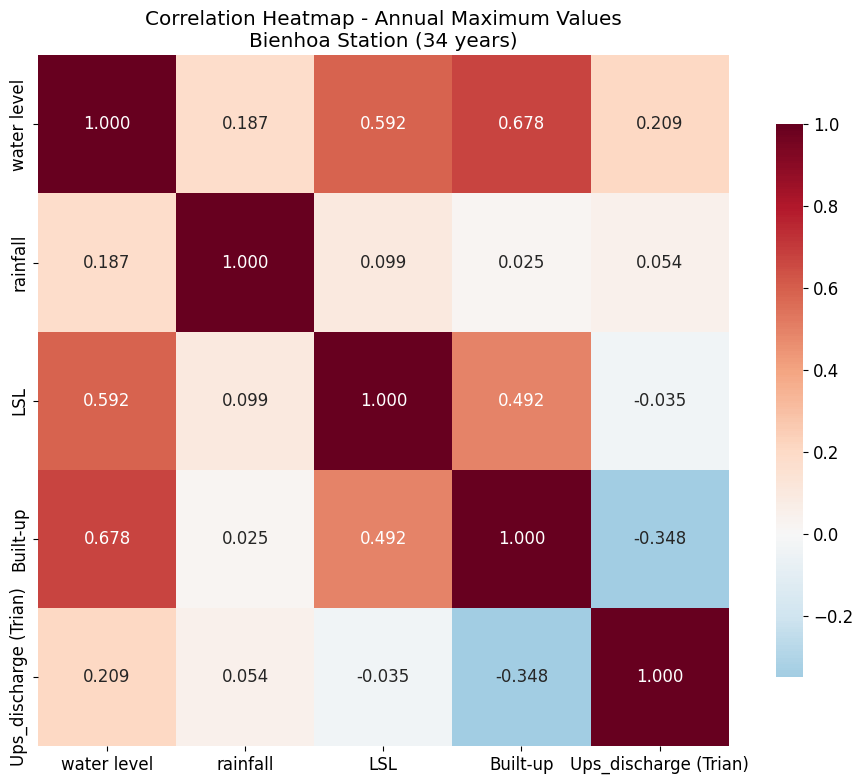


📊 Tương quan với Water Level:
   • rainfall: 0.1868 (p = 0.2900) 
   • LSL: 0.5922 (p = 0.0002) ***
   • Built-up: 0.6785 (p = 0.0000) ***
   • Ups_discharge (Trian): 0.2091 (p = 0.2353) 

🏢 Trạm: Nhabe
--------------------------------------------------
📊 Correlation Matrix cho Nhabe:
                       water level  rainfall     LSL  Built-up  \
water level                 1.0000    0.2803  0.4871    0.9074   
rainfall                    0.2803    1.0000  0.4676    0.3709   
LSL                         0.4871    0.4676  1.0000    0.4920   
Built-up                    0.9074    0.3709  0.4920    1.0000   
Ups_discharge (Trian)      -0.2797   -0.0131 -0.0353   -0.3480   

                       Ups_discharge (Trian)  
water level                          -0.2797  
rainfall                             -0.0131  
LSL                                  -0.0353  
Built-up                             -0.3480  
Ups_discharge (Trian)                 1.0000  


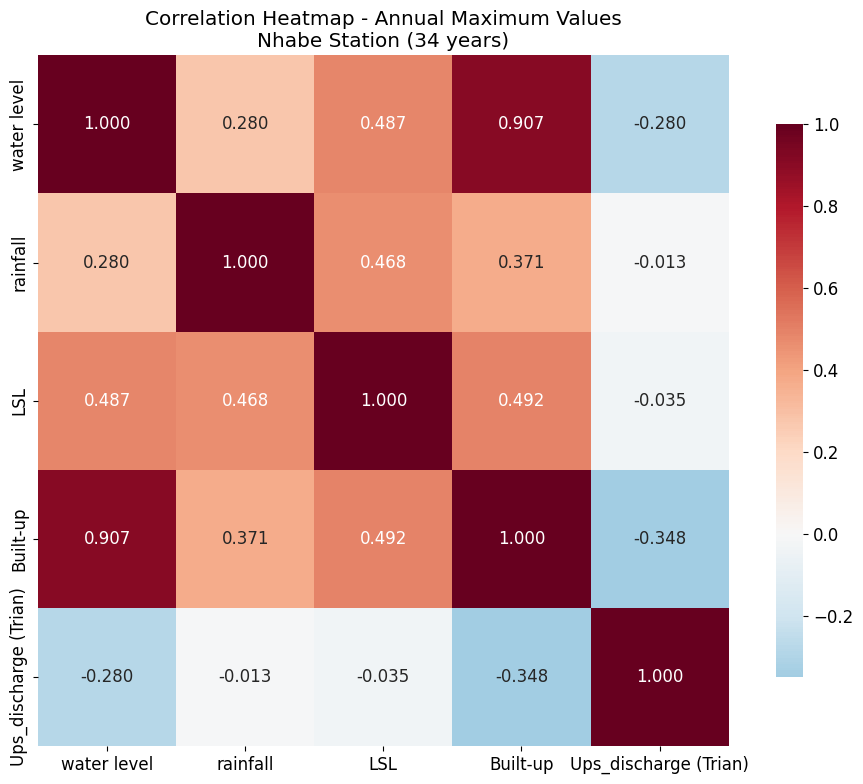


📊 Tương quan với Water Level:
   • rainfall: 0.2803 (p = 0.1083) 
   • LSL: 0.4871 (p = 0.0035) **
   • Built-up: 0.9074 (p = 0.0000) ***
   • Ups_discharge (Trian): -0.2797 (p = 0.1091) 

🏢 Trạm: Phuan
--------------------------------------------------
📊 Correlation Matrix cho Phuan:
                       water level     LSL  Built-up  Ups_discharge (Trian)
water level                 1.0000  0.5277    0.9639                -0.2730
LSL                         0.5277  1.0000    0.4920                -0.0353
Built-up                    0.9639  0.4920    1.0000                -0.3480
Ups_discharge (Trian)      -0.2730 -0.0353   -0.3480                 1.0000


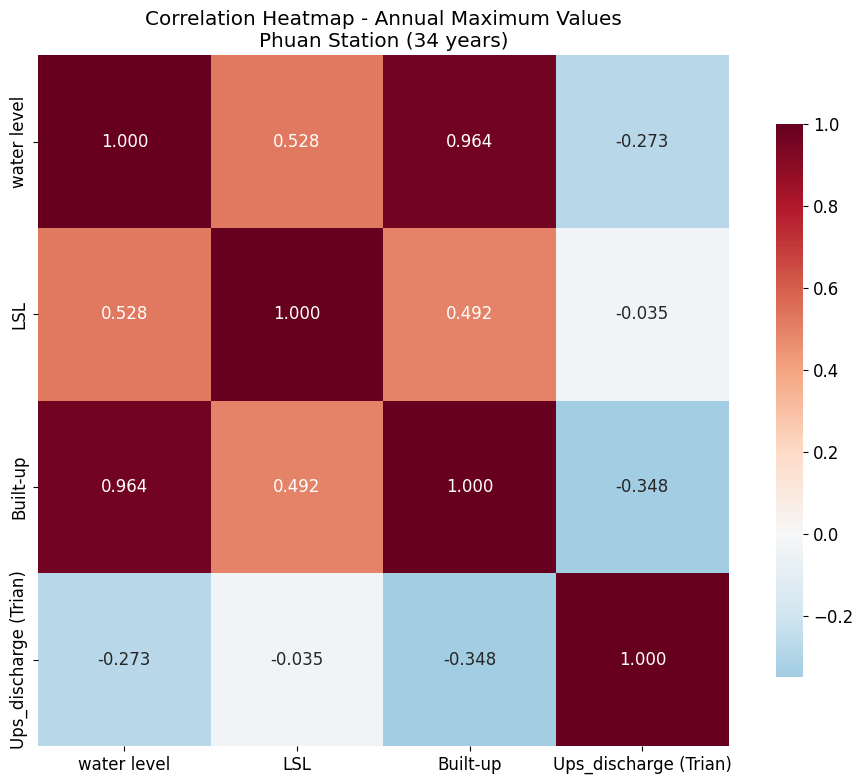


📊 Tương quan với Water Level:
   • LSL: 0.5277 (p = 0.0013) **
   • Built-up: 0.9639 (p = 0.0000) ***
   • Ups_discharge (Trian): -0.2730 (p = 0.1182) 

🏢 Trạm: Thudaumot
--------------------------------------------------
📊 Correlation Matrix cho Thudaumot:
             water level     LSL  Built-up
water level       1.0000  0.5503       NaN
LSL               0.5503  1.0000       NaN
Built-up             NaN     NaN       NaN


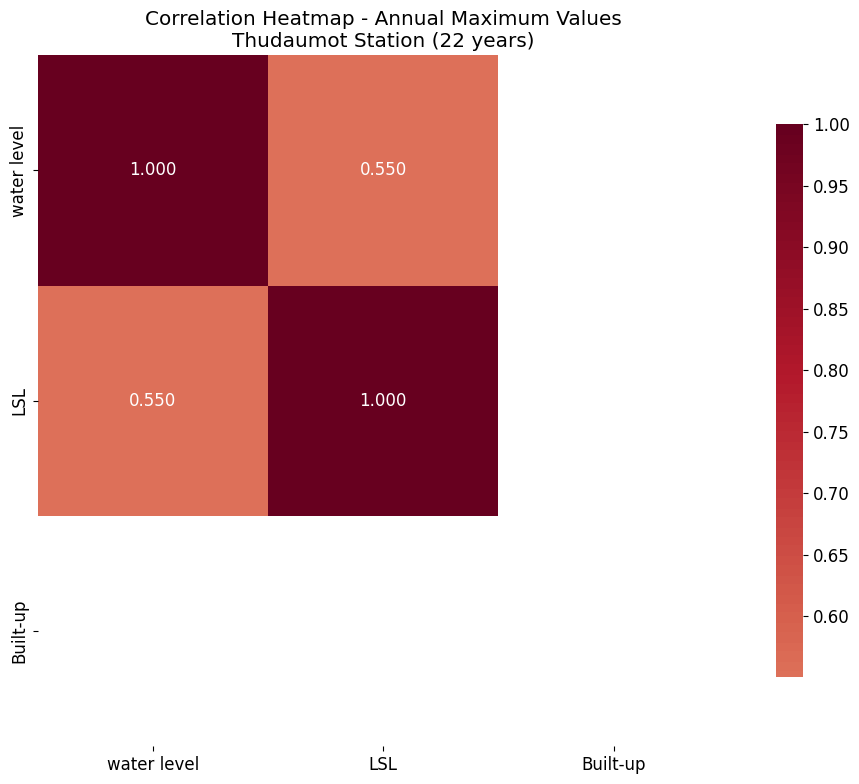


📊 Tương quan với Water Level:
   • LSL: 0.5503 (p = 0.0080) **
   • Built-up: nan (p = nan) 


In [6]:
# Tạo correlation heatmap cho từng trạm
for station, station_info in annual_max_data.items():
    print(f"\n🏢 Trạm: {station}")
    print("-" * 50)

    data = station_info['data']
    variables = station_info['variables']

    # Tính correlation matrix
    corr_matrix = data.corr()

    print(f"📊 Correlation Matrix cho {station}:")
    print(corr_matrix.round(4))

    # Tạo heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0,
                square=True, fmt='.3f', cbar_kws={"shrink": .8})
    plt.title(f'Correlation Heatmap - Annual Maximum Values\n{station} Station ({station_info["years"]} years)')
    plt.tight_layout()
    plt.savefig(f'correlation_heatmap_{station}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Phân tích correlation với water level
    if 'water level' in data.columns:
        print(f"\n📊 Tương quan với Water Level:")
        for var in variables:
            if var != 'water level':
                corr, p_val = stats.pearsonr(data['water level'], data[var])
                significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
                print(f"   • {var}: {corr:.4f} (p = {p_val:.4f}) {significance}")

In [7]:
# Hàm tính lagged correlation
def calculate_lagged_correlation(data, var1, var2, lag):
    """
    Tính lagged correlation giữa hai biến

    Parameters:
    data: DataFrame chứa dữ liệu
    var1, var2: Tên hai biến cần tính correlation
    lag: Độ trễ (lag) - số ngày

    Returns:
    correlation, p_value
    """
    # Shift var2 theo lag
    shifted_var2 = data[var2].shift(lag)

    # Tạo DataFrame với dữ liệu có sẵn
    valid_data = pd.DataFrame({
        'var1': data[var1],
        'shifted_var2': shifted_var2
    }).dropna()

    if len(valid_data) < 10:  # Ít nhất 10 điểm dữ liệu
        return np.nan, np.nan

    # Tính correlation
    corr, p_val = stats.pearsonr(valid_data['var1'], valid_data['shifted_var2'])
    return corr, p_val

print("✅ Đã định nghĩa hàm calculate_lagged_correlation")

✅ Đã định nghĩa hàm calculate_lagged_correlation



🏢 Trạm: Bienhoa
--------------------------------------------------
📊 Dữ liệu daily: 12418 ngày

📊 Lagged Correlation Matrix với rainfall:
                       Lag -3  Lag -2  Lag -1   Lag 0   Lag 1   Lag 2   Lag 3
water level            0.0094  0.0144  0.0182  0.0303  0.0478  0.0573  0.0622
LSL                    0.0094  0.0144  0.0182  0.0303  0.0478  0.0573  0.0622
Built-up               0.0094  0.0144  0.0182  0.0303  0.0478  0.0573  0.0622
Ups_discharge (Trian)  0.0094  0.0144  0.0182  0.0303  0.0478  0.0573  0.0622


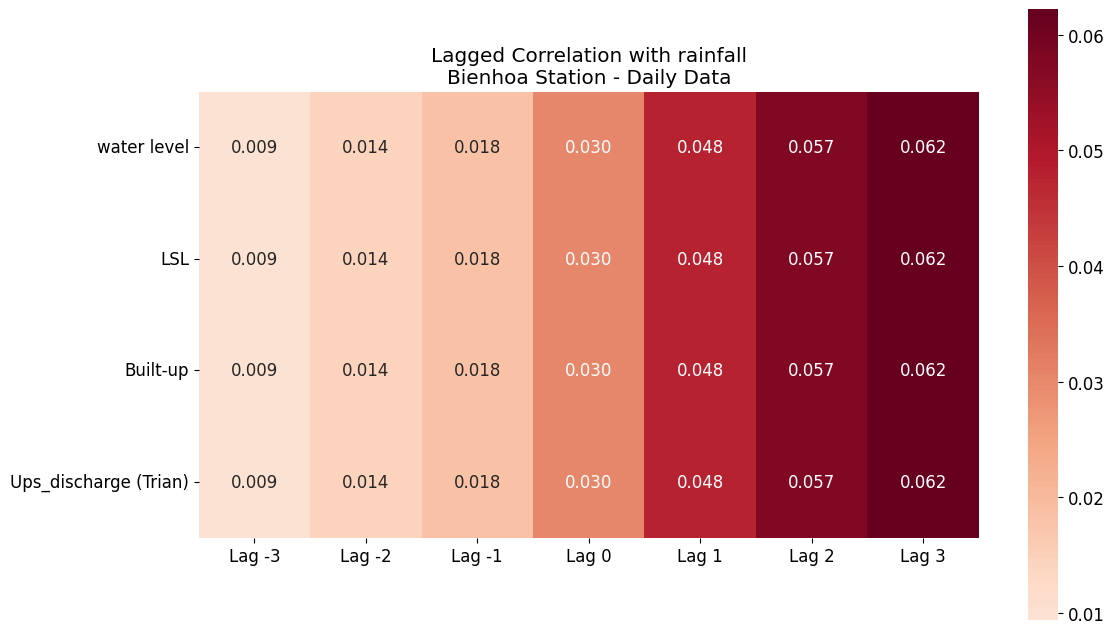


🏆 Lag tốt nhất cho từng biến:
   • water level: Lag 3 = 0.0622

🏢 Trạm: Nhabe
--------------------------------------------------
📊 Dữ liệu daily: 12418 ngày

📊 Lagged Correlation Matrix với rainfall:
                       Lag -3  Lag -2  Lag -1   Lag 0   Lag 1   Lag 2   Lag 3
water level           -0.0112 -0.0103 -0.0083 -0.0114  0.0011 -0.0041 -0.0001
LSL                   -0.0112 -0.0103 -0.0083 -0.0114  0.0011 -0.0041 -0.0001
Built-up              -0.0112 -0.0103 -0.0083 -0.0114  0.0011 -0.0041 -0.0001
Ups_discharge (Trian) -0.0112 -0.0103 -0.0083 -0.0114  0.0011 -0.0041 -0.0001


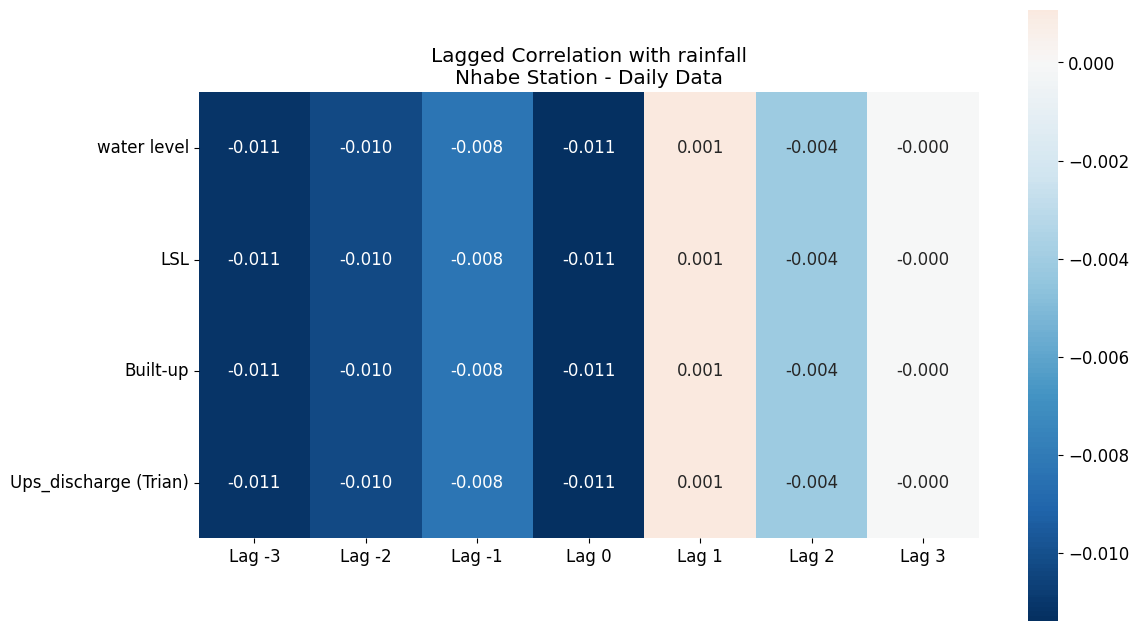


🏆 Lag tốt nhất cho từng biến:
   • water level: Lag 0 = -0.0114

🏢 Trạm: Phuan
--------------------------------------------------
❌ Không tìm thấy biến rainfall trong Phuan

🏢 Trạm: Thudaumot
--------------------------------------------------
❌ Không tìm thấy biến rainfall trong Thudaumot


In [8]:
# Phân tích lagged correlation cho từng trạm
lags = range(-3, 4)  # Từ -3 đến +3 ngày

for station, station_info in annual_max_data.items():
    print(f"\n🏢 Trạm: {station}")
    print("-" * 50)

    data = station_info['data']
    variables = station_info['variables']
    raw_data = station_info['raw_data']

    # Tìm biến rainfall
    rainfall_var = None
    for var in variables:
        if 'rainfall' in var.lower():
            rainfall_var = var
            break

    if rainfall_var is None:
        print(f"❌ Không tìm thấy biến rainfall trong {station}")
        continue

    # Kiểm tra có dữ liệu daily không
    if 'water level' not in raw_data.columns or rainfall_var not in raw_data.columns:
        print(f"❌ Thiếu water level hoặc {rainfall_var} trong dữ liệu daily")
        continue

    # Lọc dữ liệu daily có sẵn
    daily_data = raw_data[['Times', 'water level', rainfall_var]].dropna()

    if len(daily_data) == 0:
        print(f"❌ Không có dữ liệu daily cho {station}")
        continue

    print(f"📊 Dữ liệu daily: {len(daily_data)} ngày")

    # Tính lagged correlation
    corr_matrix = []
    p_matrix = []

    # Các biến cần phân tích (trừ rainfall)
    target_vars = [var for var in variables if var != rainfall_var]

    for var in target_vars:
        if var in daily_data.columns:
            corr_row = []
            p_row = []

            for lag in lags:
                corr, p_val = calculate_lagged_correlation(daily_data, var, rainfall_var, lag)
                corr_row.append(corr)
                p_row.append(p_val)

            corr_matrix.append(corr_row)
            p_matrix.append(p_row)

    if corr_matrix:
        # Tạo DataFrame cho heatmap
        corr_df = pd.DataFrame(corr_matrix,
                              index=target_vars,
                              columns=[f'Lag {lag}' for lag in lags])

        print(f"\n📊 Lagged Correlation Matrix với {rainfall_var}:")
        print(corr_df.round(4))

        # Tạo heatmap
        plt.figure(figsize=(12, 8))
        sns.heatmap(corr_df, annot=True, cmap='RdBu_r', center=0,
                    square=True, fmt='.3f', cbar_kws={"shrink": .8})
        plt.title(f'Lagged Correlation with {rainfall_var}\n{station} Station - Daily Data')
        plt.tight_layout()
        plt.savefig(f'lagged_correlation_heatmap_{station}.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Tìm lag tốt nhất cho từng biến
        print(f"\n🏆 Lag tốt nhất cho từng biến:")
        for i, var in enumerate(target_vars):
            if i < len(corr_matrix):
                corr_values = corr_matrix[i]
                max_corr_idx = np.nanargmax(np.abs(corr_values))
                max_corr = corr_values[max_corr_idx]
                max_lag = lags[max_corr_idx]
                print(f"   • {var}: Lag {max_lag} = {max_corr:.4f}")

📅 Phân tích theo giai đoạn thời gian...

🏢 Trạm: Bienhoa
   ✅ Đã lưu: time_period_analysis_Bienhoa.png


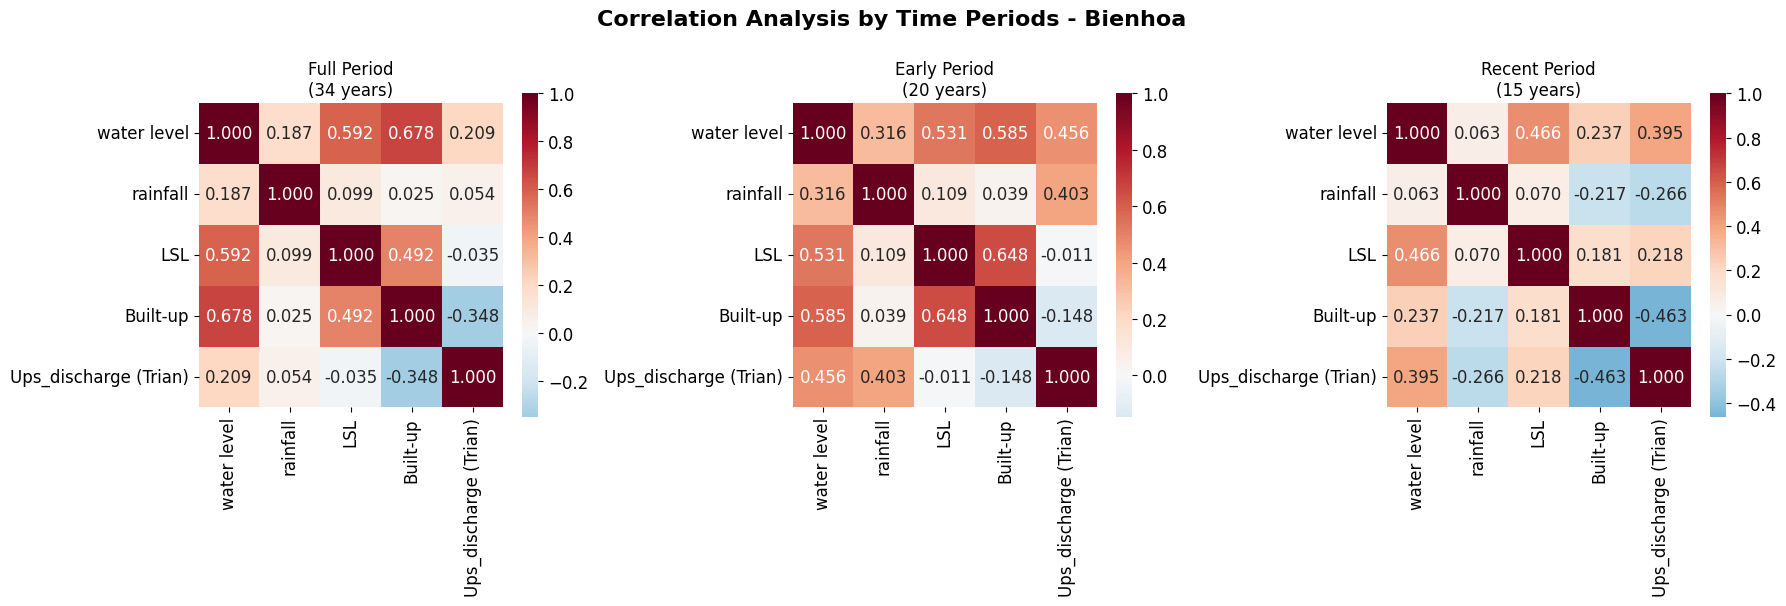

   📊 Full Period (34 years):
      • Correlation cao nhất: 1.000
      • Correlation thấp nhất: -0.348
   📊 Early Period (20 years):
      • Correlation cao nhất: 1.000
      • Correlation thấp nhất: -0.148
   📊 Recent Period (15 years):
      • Correlation cao nhất: 1.000
      • Correlation thấp nhất: -0.463

🏢 Trạm: Nhabe
   ✅ Đã lưu: time_period_analysis_Nhabe.png


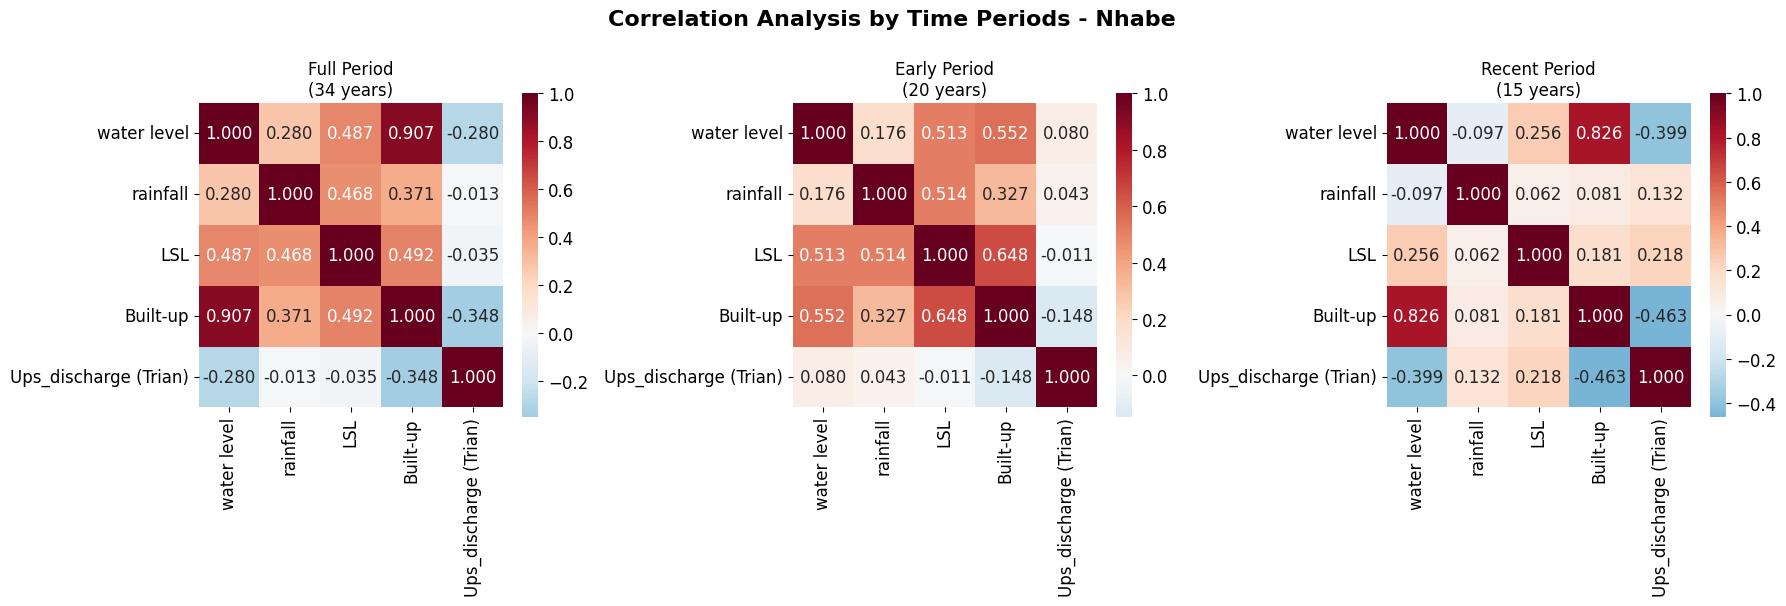

   📊 Full Period (34 years):
      • Correlation cao nhất: 1.000
      • Correlation thấp nhất: -0.348
   📊 Early Period (20 years):
      • Correlation cao nhất: 1.000
      • Correlation thấp nhất: -0.148
   📊 Recent Period (15 years):
      • Correlation cao nhất: 1.000
      • Correlation thấp nhất: -0.463

🏢 Trạm: Phuan
   ✅ Đã lưu: time_period_analysis_Phuan.png


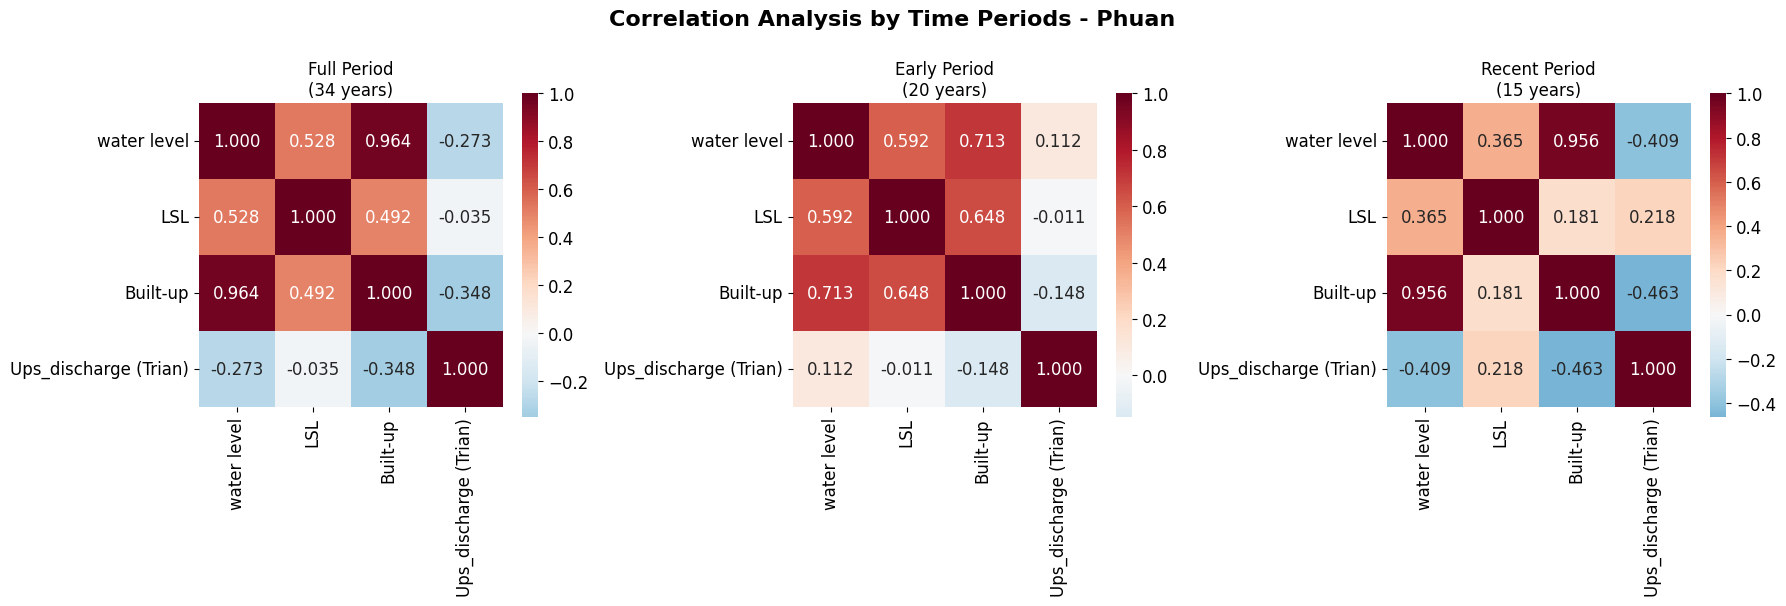

   📊 Full Period (34 years):
      • Correlation cao nhất: 1.000
      • Correlation thấp nhất: -0.348
   📊 Early Period (20 years):
      • Correlation cao nhất: 1.000
      • Correlation thấp nhất: -0.148
   📊 Recent Period (15 years):
      • Correlation cao nhất: 1.000
      • Correlation thấp nhất: -0.463

🏢 Trạm: Thudaumot
   ✅ Đã lưu: time_period_analysis_Thudaumot.png


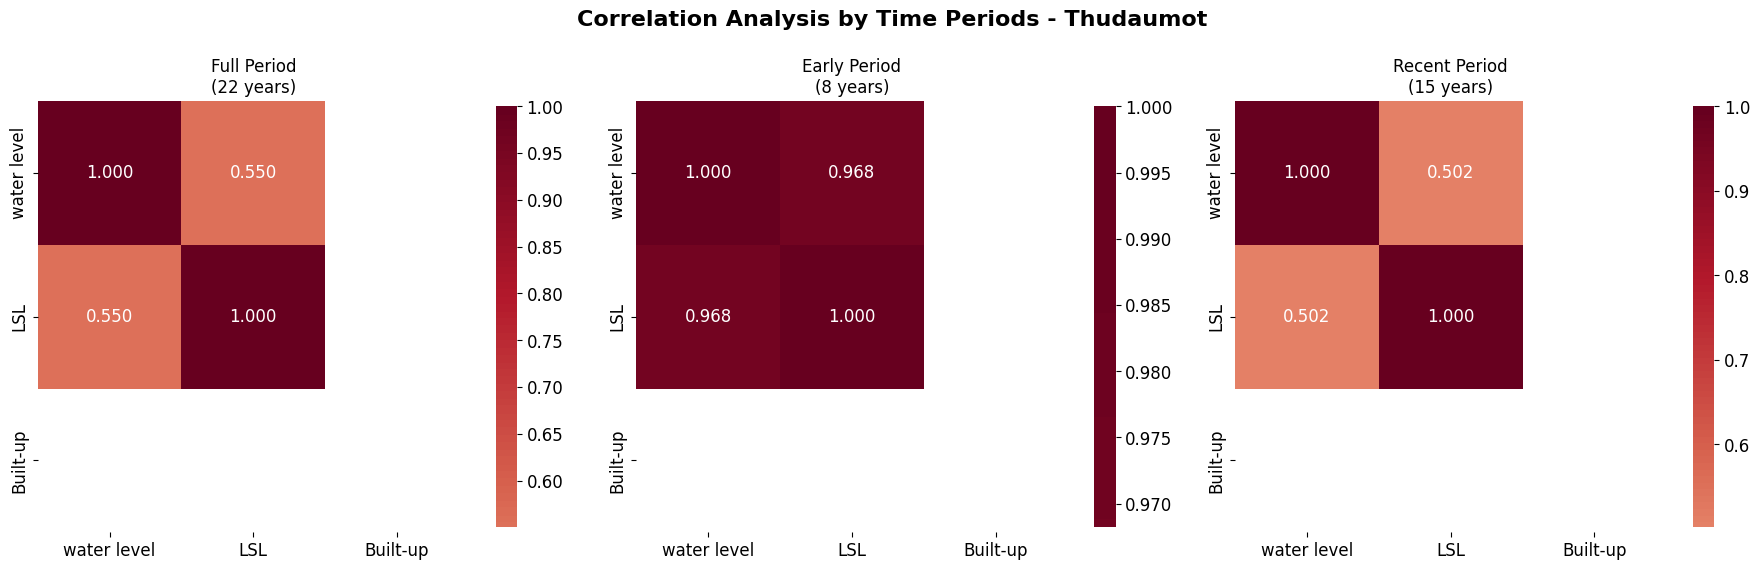

   📊 Full Period (22 years):
      • Correlation cao nhất: 1.000
      • Correlation thấp nhất: 0.550
   📊 Early Period (8 years):
      • Correlation cao nhất: 1.000
      • Correlation thấp nhất: 0.968
   📊 Recent Period (15 years):
      • Correlation cao nhất: 1.000
      • Correlation thấp nhất: 0.502


In [9]:
# Phân tích theo giai đoạn thời gian
print("📅 Phân tích theo giai đoạn thời gian...")

for station, station_info in annual_max_data.items():
    print(f"\n🏢 Trạm: {station}")

    data = station_info['data']
    variables = station_info['variables']

    # Chia thành các giai đoạn
    periods = {
        'Full Period': data,
        'Early Period': data[data.index <= 2000],
        'Recent Period': data[data.index >= 2000]
    }

    # Tạo subplot cho từng giai đoạn
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'Correlation Analysis by Time Periods - {station}', fontsize=16, fontweight='bold')

    for i, (period_name, period_data) in enumerate(periods.items()):
        if len(period_data) < 3:
            print(f"   ⚠️ Giai đoạn {period_name} có ít dữ liệu ({len(period_data)} năm)")
            continue

        # Tính correlation
        corr_matrix = period_data.corr()

        # Vẽ heatmap đầy đủ
        sns.heatmap(corr_matrix,
                    annot=True,
                    cmap='RdBu_r',
                    center=0,
                    square=True,
                    fmt='.3f',
                    ax=axes[i],
                    cbar_kws={"shrink": .8})

        axes[i].set_title(f'{period_name}\n({len(period_data)} years)', fontsize=12)

    plt.tight_layout()

    # Lưu biểu đồ
    filename = f'time_period_analysis_{station}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"   ✅ Đã lưu: {filename}")

    plt.show()

    # Hiển thị thống kê từng giai đoạn
    for period_name, period_data in periods.items():
        if len(period_data) >= 3:
            corr_matrix = period_data.corr()
            print(f"   📊 {period_name} ({len(period_data)} years):")
            print(f"      • Correlation cao nhất: {corr_matrix.max().max():.3f}")
            print(f"      • Correlation thấp nhất: {corr_matrix.min().min():.3f}")


🏢 Trạm: Bienhoa
--------------------------------------------------


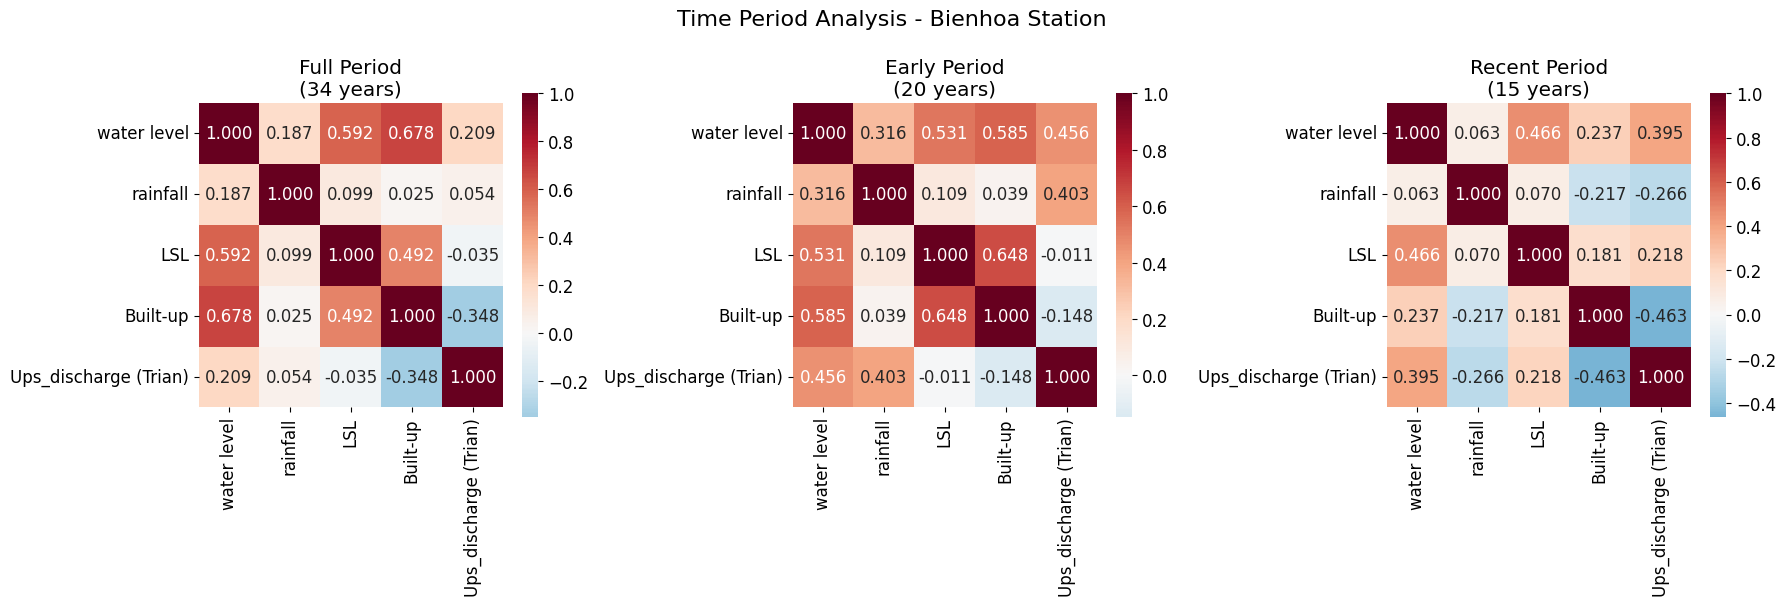


📅 Full Period (34 years):
   • rainfall: 0.1868 (p = 0.2900)
   • LSL: 0.5922 (p = 0.0002)
   • Built-up: 0.6785 (p = 0.0000)
   • Ups_discharge (Trian): 0.2091 (p = 0.2353)

📅 Early Period (20 years):
   • rainfall: 0.3165 (p = 0.1740)
   • LSL: 0.5315 (p = 0.0159)
   • Built-up: 0.5848 (p = 0.0068)
   • Ups_discharge (Trian): 0.4564 (p = 0.0431)

📅 Recent Period (15 years):
   • rainfall: 0.0630 (p = 0.8234)
   • LSL: 0.4660 (p = 0.0800)
   • Built-up: 0.2368 (p = 0.3955)
   • Ups_discharge (Trian): 0.3951 (p = 0.1450)

🏢 Trạm: Nhabe
--------------------------------------------------


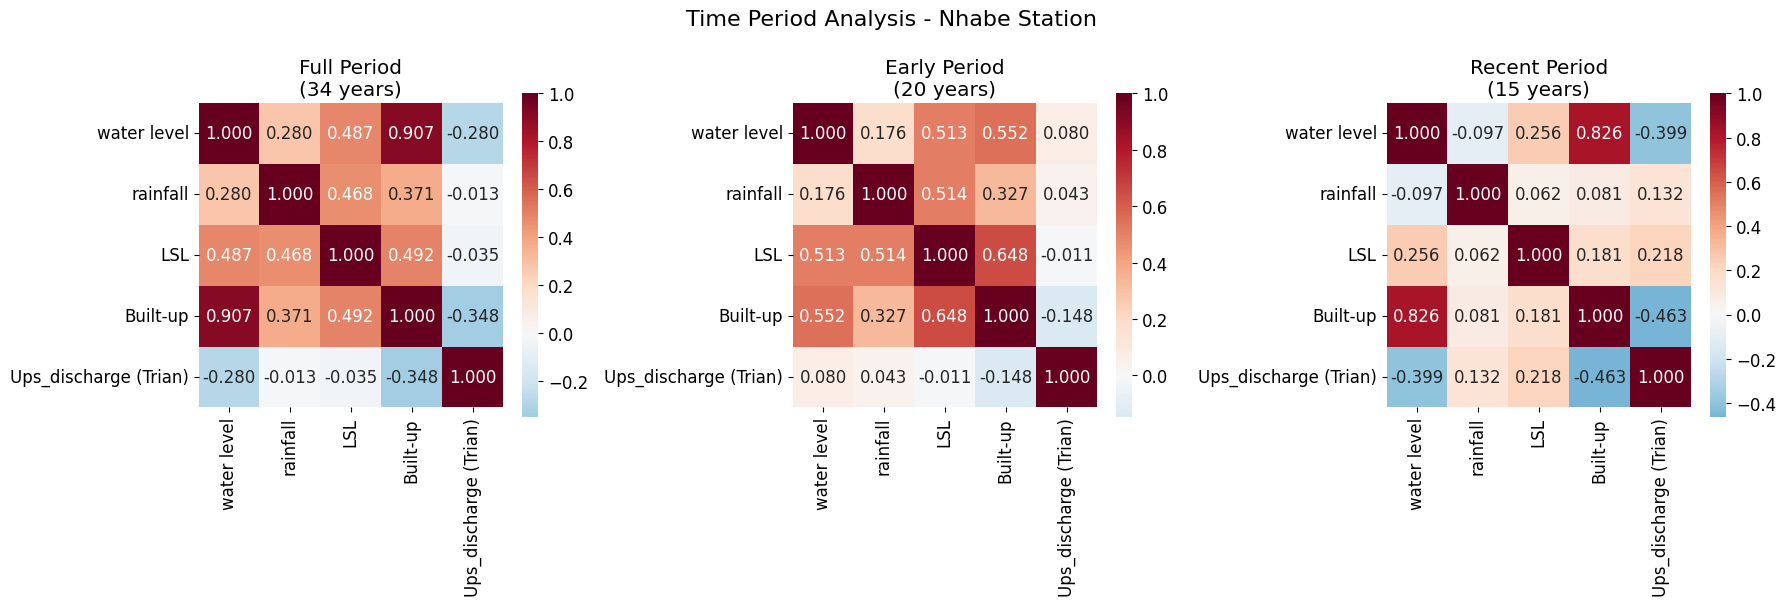


📅 Full Period (34 years):
   • rainfall: 0.2803 (p = 0.1083)
   • LSL: 0.4871 (p = 0.0035)
   • Built-up: 0.9074 (p = 0.0000)
   • Ups_discharge (Trian): -0.2797 (p = 0.1091)

📅 Early Period (20 years):
   • rainfall: 0.1759 (p = 0.4583)
   • LSL: 0.5128 (p = 0.0208)
   • Built-up: 0.5519 (p = 0.0116)
   • Ups_discharge (Trian): 0.0798 (p = 0.7382)

📅 Recent Period (15 years):
   • rainfall: -0.0971 (p = 0.7305)
   • LSL: 0.2558 (p = 0.3575)
   • Built-up: 0.8256 (p = 0.0002)
   • Ups_discharge (Trian): -0.3992 (p = 0.1405)

🏢 Trạm: Phuan
--------------------------------------------------


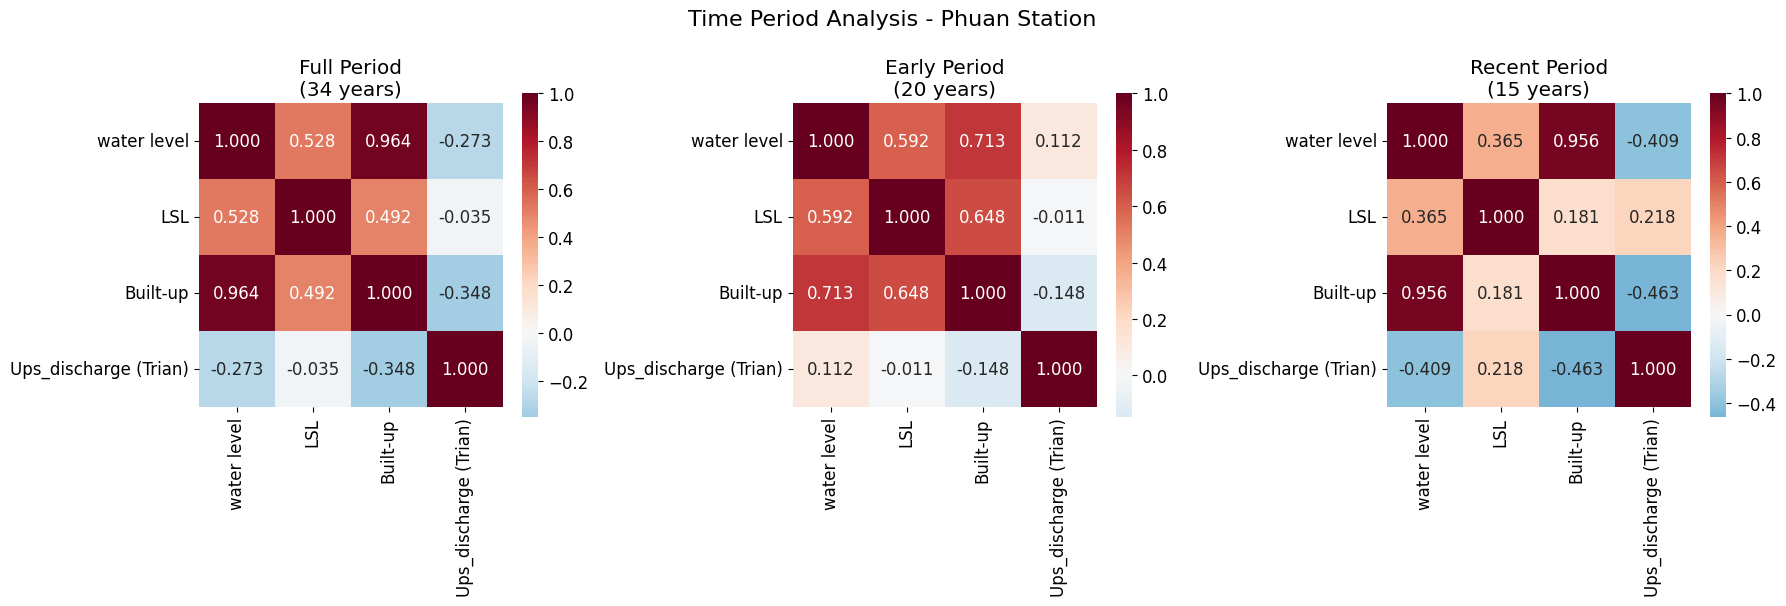


📅 Full Period (34 years):
   • LSL: 0.5277 (p = 0.0013)
   • Built-up: 0.9639 (p = 0.0000)
   • Ups_discharge (Trian): -0.2730 (p = 0.1182)

📅 Early Period (20 years):
   • LSL: 0.5921 (p = 0.0060)
   • Built-up: 0.7128 (p = 0.0004)
   • Ups_discharge (Trian): 0.1123 (p = 0.6375)

📅 Recent Period (15 years):
   • LSL: 0.3651 (p = 0.1809)
   • Built-up: 0.9561 (p = 0.0000)
   • Ups_discharge (Trian): -0.4089 (p = 0.1302)

🏢 Trạm: Thudaumot
--------------------------------------------------


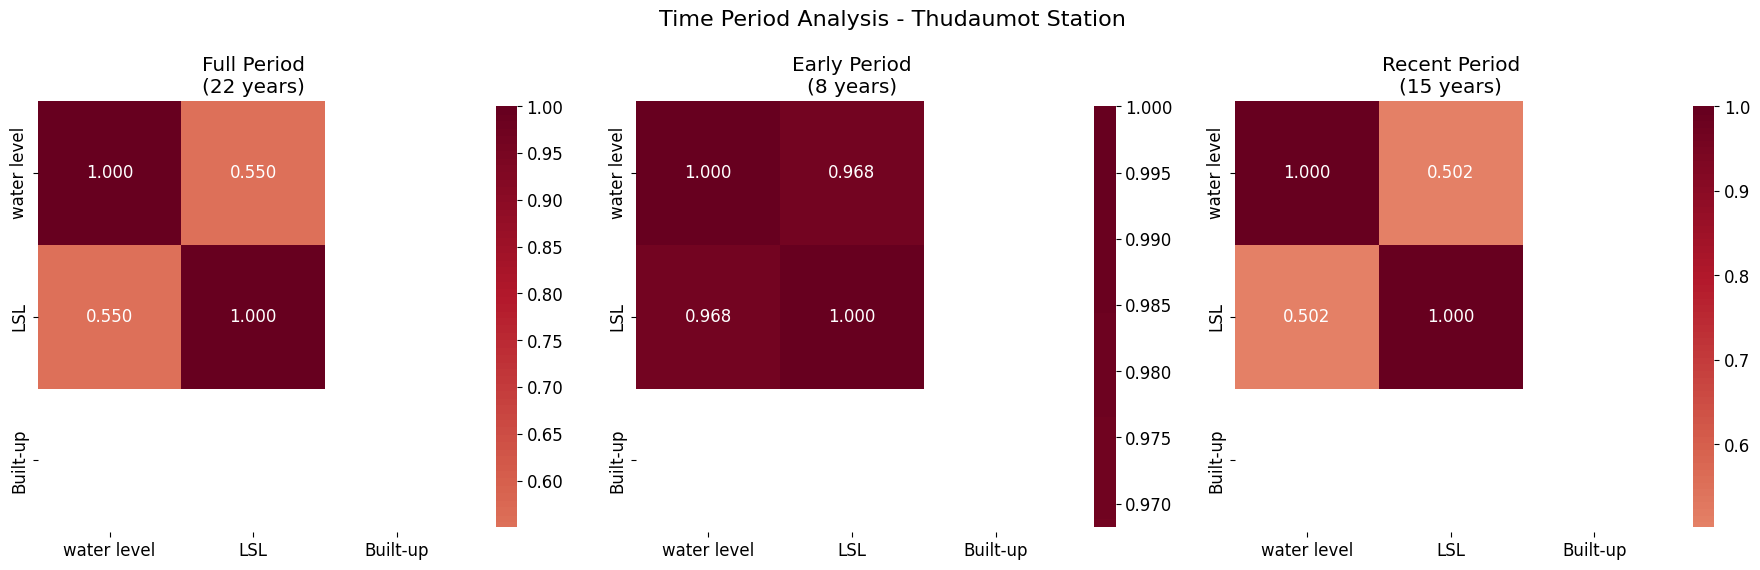


📅 Full Period (22 years):
   • LSL: 0.5503 (p = 0.0080)
   • Built-up: nan (p = nan)

📅 Early Period (8 years):
   • LSL: 0.9682 (p = 0.0001)
   • Built-up: nan (p = nan)

📅 Recent Period (15 years):
   • LSL: 0.5020 (p = 0.0566)
   • Built-up: nan (p = nan)


In [10]:
# Phân tích theo giai đoạn thời gian cho từng trạm
for station, station_info in annual_max_data.items():
    print(f"\n🏢 Trạm: {station}")
    print("-" * 50)

    data = station_info['data']

    # Chia thành các giai đoạn
    periods = {
        'Full Period': data,
        'Early Period': data[data.index <= 2000],
        'Recent Period': data[data.index >= 2000]
    }

    # Tạo subplot cho từng giai đoạn
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for i, (period_name, period_data) in enumerate(periods.items()):
        if len(period_data) >= 3:  # Ít nhất 3 năm
            corr_matrix = period_data.corr()

            sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0,
                        square=True, fmt='.3f', ax=axes[i], cbar_kws={"shrink": .8})
            axes[i].set_title(f'{period_name}\n({len(period_data)} years)')
        else:
            axes[i].text(0.5, 0.5, f'Insufficient data\n({len(period_data)} years)',
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(period_name)

    plt.suptitle(f'Time Period Analysis - {station} Station', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'time_period_analysis_{station}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # In thống kê cho từng giai đoạn
    for period_name, period_data in periods.items():
        if len(period_data) >= 3:
            print(f"\n📅 {period_name} ({len(period_data)} years):")
            if 'water level' in period_data.columns:
                for var in period_data.columns:
                    if var != 'water level':
                        corr, p_val = stats.pearsonr(period_data['water level'], period_data[var])
                        print(f"   • {var}: {corr:.4f} (p = {p_val:.4f})")

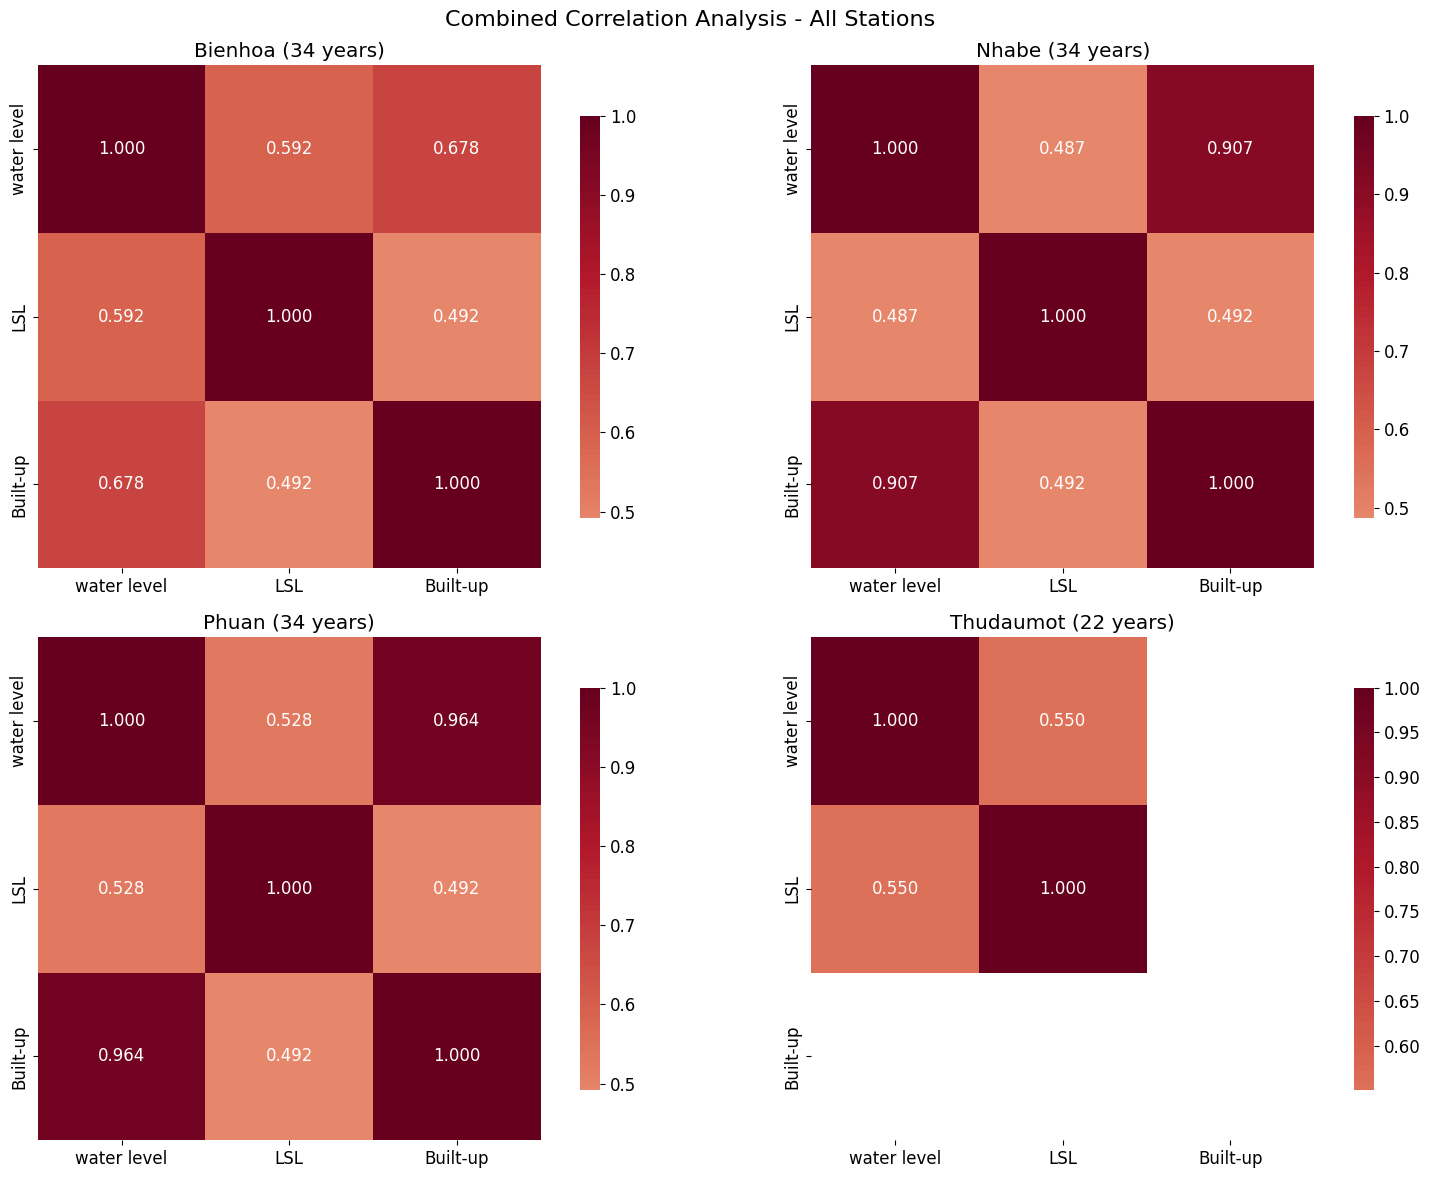

✅ Đã tạo biểu đồ tổng hợp cho tất cả trạm!


In [11]:
# Tạo biểu đồ tổng hợp cho tất cả trạm
all_data = []

for station, station_info in annual_max_data.items():
    data = station_info['data'].copy()
    data['Station'] = station
    all_data.append(data)

if all_data:
    combined_data = pd.concat(all_data, ignore_index=False)

    # Tìm biến chung giữa các trạm
    common_vars = set.intersection(*[set(station_info['variables']) for station_info in annual_max_data.values()])

    if len(common_vars) >= 2:
        # Tạo subplot cho từng trạm
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        for i, (station, station_info) in enumerate(annual_max_data.items()):
            row, col = i // 2, i % 2
            data = station_info['data']

            # Lọc biến chung có sẵn
            common_vars_station = [var for var in station_info['variables'] if var in common_vars]

            if len(common_vars_station) >= 2:
                corr_matrix = data[common_vars_station].corr()

                sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0,
                            square=True, fmt='.3f', ax=axes[row, col], cbar_kws={"shrink": .8})
                axes[row, col].set_title(f'{station} ({station_info["years"]} years)')

        plt.suptitle('Combined Correlation Analysis - All Stations', fontsize=16)
        plt.tight_layout()
        plt.savefig('combined_correlation_heatmap.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("✅ Đã tạo biểu đồ tổng hợp cho tất cả trạm!")

In [12]:
# Tóm tắt kết quả phân tích
print("📊 TÓM TẮT KẾT QUẢ PHÂN TÍCH")
print("=" * 60)

print(f"📋 Thông tin tổng quan:")
print(f"• Số trạm phân tích: {len(annual_max_data)}")
print(f"• Tên các trạm: {list(annual_max_data.keys())}")

for station, station_info in annual_max_data.items():
    print(f"\n🏢 Trạm {station}:")
    print(f"   • Số năm dữ liệu: {station_info['years']}")
    print(f"   • Các biến: {station_info['variables']}")

    # Tìm biến có tương quan mạnh nhất với water level
    if 'water level' in station_info['data'].columns:
        data = station_info['data']
        correlations = {}

        for var in data.columns:
            if var != 'water level':
                corr, p_val = stats.pearsonr(data['water level'], data[var])
                correlations[var] = corr

        if correlations:
            strongest_var = max(correlations.keys(), key=lambda x: abs(correlations[x]))
            strongest_corr = correlations[strongest_var]
            print(f"   • Biến có tương quan mạnh nhất với water level: {strongest_var} = {strongest_corr:.4f}")

print(f"\n✅ Hoàn thành phân tích toàn bộ dữ liệu!")
print(f"📁 Các file biểu đồ đã được lưu:")
print(f"   • correlation_heatmap_[station].png")
print(f"   • lagged_correlation_heatmap_[station].png")
print(f"   • time_period_analysis_[station].png")
print(f"   • combined_correlation_heatmap.png")

📊 TÓM TẮT KẾT QUẢ PHÂN TÍCH
📋 Thông tin tổng quan:
• Số trạm phân tích: 4
• Tên các trạm: ['Bienhoa', 'Nhabe', 'Phuan', 'Thudaumot']

🏢 Trạm Bienhoa:
   • Số năm dữ liệu: 34
   • Các biến: ['water level', 'rainfall', 'LSL', 'Built-up', 'Ups_discharge (Trian)']
   • Biến có tương quan mạnh nhất với water level: Built-up = 0.6785

🏢 Trạm Nhabe:
   • Số năm dữ liệu: 34
   • Các biến: ['water level', 'rainfall', 'LSL', 'Built-up', 'Ups_discharge (Trian)']
   • Biến có tương quan mạnh nhất với water level: Built-up = 0.9074

🏢 Trạm Phuan:
   • Số năm dữ liệu: 34
   • Các biến: ['water level', 'LSL', 'Built-up', 'Ups_discharge (Trian)']
   • Biến có tương quan mạnh nhất với water level: Built-up = 0.9639

🏢 Trạm Thudaumot:
   • Số năm dữ liệu: 22
   • Các biến: ['water level', 'LSL', 'Built-up']
   • Biến có tương quan mạnh nhất với water level: LSL = 0.5503

✅ Hoàn thành phân tích toàn bộ dữ liệu!
📁 Các file biểu đồ đã được lưu:
   • correlation_heatmap_[station].png
   • lagged_correlation

🔍 PHÂN TÍCH CHI TIẾT ĐỂ CHỨNG MINH TÍNH ĐÚNG ĐẮN

🏢 TRẠM: Bienhoa
--------------------------------------------------
📊 Dữ liệu daily: 12418 ngày

📊 SO SÁNH TƯƠNG QUAn:
--------------------------------------------------
   • Lag 0 (đồng thời):     0.0303 (p = 0.0007)
   • Lag +1 (rainfall trước): 0.0182 (p = 0.0426)
   • Lag -1 (rainfall sau):   0.0478 (p = 0.0000)

🔍 PHÂN TÍCH CHI TIẾT VỚI NHIỀU LAG:
----------------------------------------
📋 Chi tiết các lag:
   • Lag -7: -0.0007 (p = 0.9418) 
   • Lag -6: 0.0006 (p = 0.9432) 
   • Lag -5: 0.0024 (p = 0.7922) 
   • Lag -4: 0.0048 (p = 0.5892) 
   • Lag -3: 0.0094 (p = 0.2966) 
   • Lag -2: 0.0144 (p = 0.1074) 
   • Lag -1: 0.0182 (p = 0.0426) *
   • Lag 0: 0.0303 (p = 0.0007) ***
   • Lag 1: 0.0478 (p = 0.0000) ***
   • Lag 2: 0.0573 (p = 0.0000) ***
   • Lag 3: 0.0622 (p = 0.0000) ***
   • Lag 4: 0.0608 (p = 0.0000) ***
   • Lag 5: 0.0580 (p = 0.0000) ***
   • Lag 6: 0.0568 (p = 0.0000) ***
   • Lag 7: 0.0550 (p = 0.0000) ***

🏆 LAG 

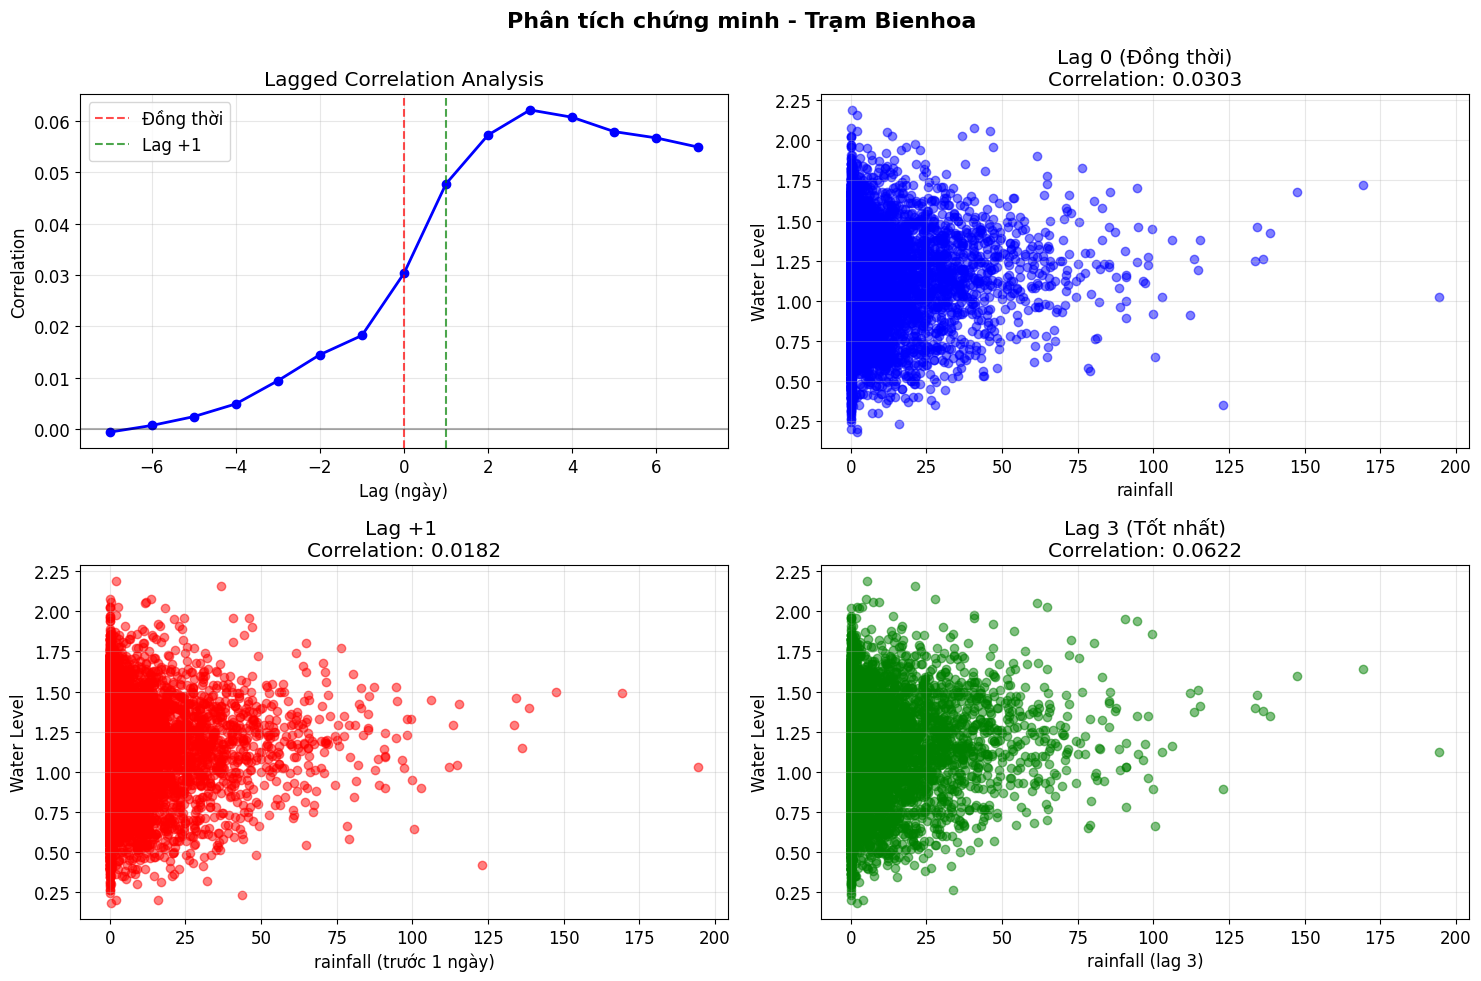


🏢 TRẠM: Nhabe
--------------------------------------------------
📊 Dữ liệu daily: 12418 ngày

📊 SO SÁNH TƯƠNG QUAn:
--------------------------------------------------
   • Lag 0 (đồng thời):     -0.0114 (p = 0.2042)
   • Lag +1 (rainfall trước): -0.0083 (p = 0.3531)
   • Lag -1 (rainfall sau):   0.0011 (p = 0.9047)

🔍 PHÂN TÍCH CHI TIẾT VỚI NHIỀU LAG:
----------------------------------------
📋 Chi tiết các lag:
   • Lag -7: -0.0022 (p = 0.8099) 
   • Lag -6: -0.0106 (p = 0.2361) 
   • Lag -5: -0.0088 (p = 0.3286) 
   • Lag -4: -0.0146 (p = 0.1046) 
   • Lag -3: -0.0112 (p = 0.2134) 
   • Lag -2: -0.0103 (p = 0.2533) 
   • Lag -1: -0.0083 (p = 0.3531) 
   • Lag 0: -0.0114 (p = 0.2042) 
   • Lag 1: 0.0011 (p = 0.9047) 
   • Lag 2: -0.0041 (p = 0.6464) 
   • Lag 3: -0.0001 (p = 0.9932) 
   • Lag 4: 0.0042 (p = 0.6435) 
   • Lag 5: 0.0027 (p = 0.7597) 
   • Lag 6: 0.0014 (p = 0.8750) 
   • Lag 7: 0.0046 (p = 0.6061) 

🏆 LAG TỐT NHẤT: Lag -4 = -0.0146 (p = 0.1046)
✅ Lag -4 có tương quan ca

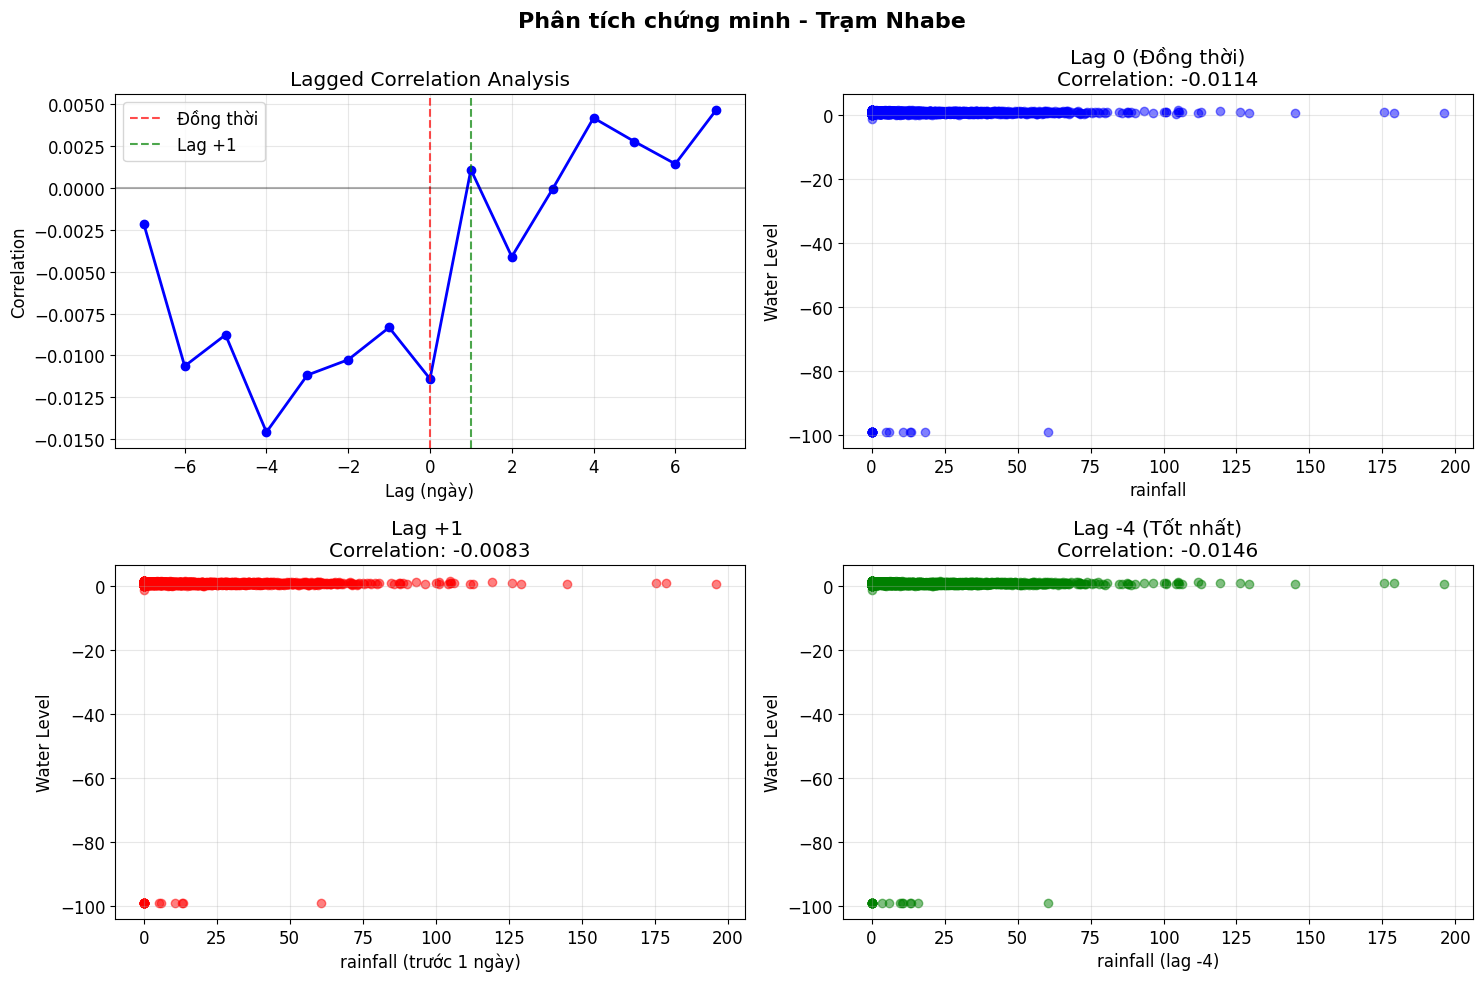


🏢 TRẠM: Phuan
--------------------------------------------------
📊 Dữ liệu daily: 12418 ngày

📊 SO SÁNH TƯƠNG QUAn:
--------------------------------------------------
   • Lag 0 (đồng thời):     -0.0068 (p = 0.4520)
   • Lag +1 (rainfall trước): -0.0095 (p = 0.2897)
   • Lag -1 (rainfall sau):   -0.0060 (p = 0.5058)

🔍 PHÂN TÍCH CHI TIẾT VỚI NHIỀU LAG:
----------------------------------------
📋 Chi tiết các lag:
   • Lag -7: -0.0162 (p = 0.0704) 
   • Lag -6: -0.0149 (p = 0.0974) 
   • Lag -5: -0.0141 (p = 0.1157) 
   • Lag -4: -0.0137 (p = 0.1266) 
   • Lag -3: -0.0124 (p = 0.1656) 
   • Lag -2: -0.0109 (p = 0.2232) 
   • Lag -1: -0.0095 (p = 0.2897) 
   • Lag 0: -0.0068 (p = 0.4520) 
   • Lag 1: -0.0060 (p = 0.5058) 
   • Lag 2: -0.0051 (p = 0.5701) 
   • Lag 3: -0.0057 (p = 0.5282) 
   • Lag 4: -0.0058 (p = 0.5162) 
   • Lag 5: -0.0065 (p = 0.4677) 
   • Lag 6: -0.0064 (p = 0.4776) 
   • Lag 7: -0.0054 (p = 0.5479) 

🏆 LAG TỐT NHẤT: Lag -7 = -0.0162 (p = 0.0704)
✅ Lag -7 có tương q

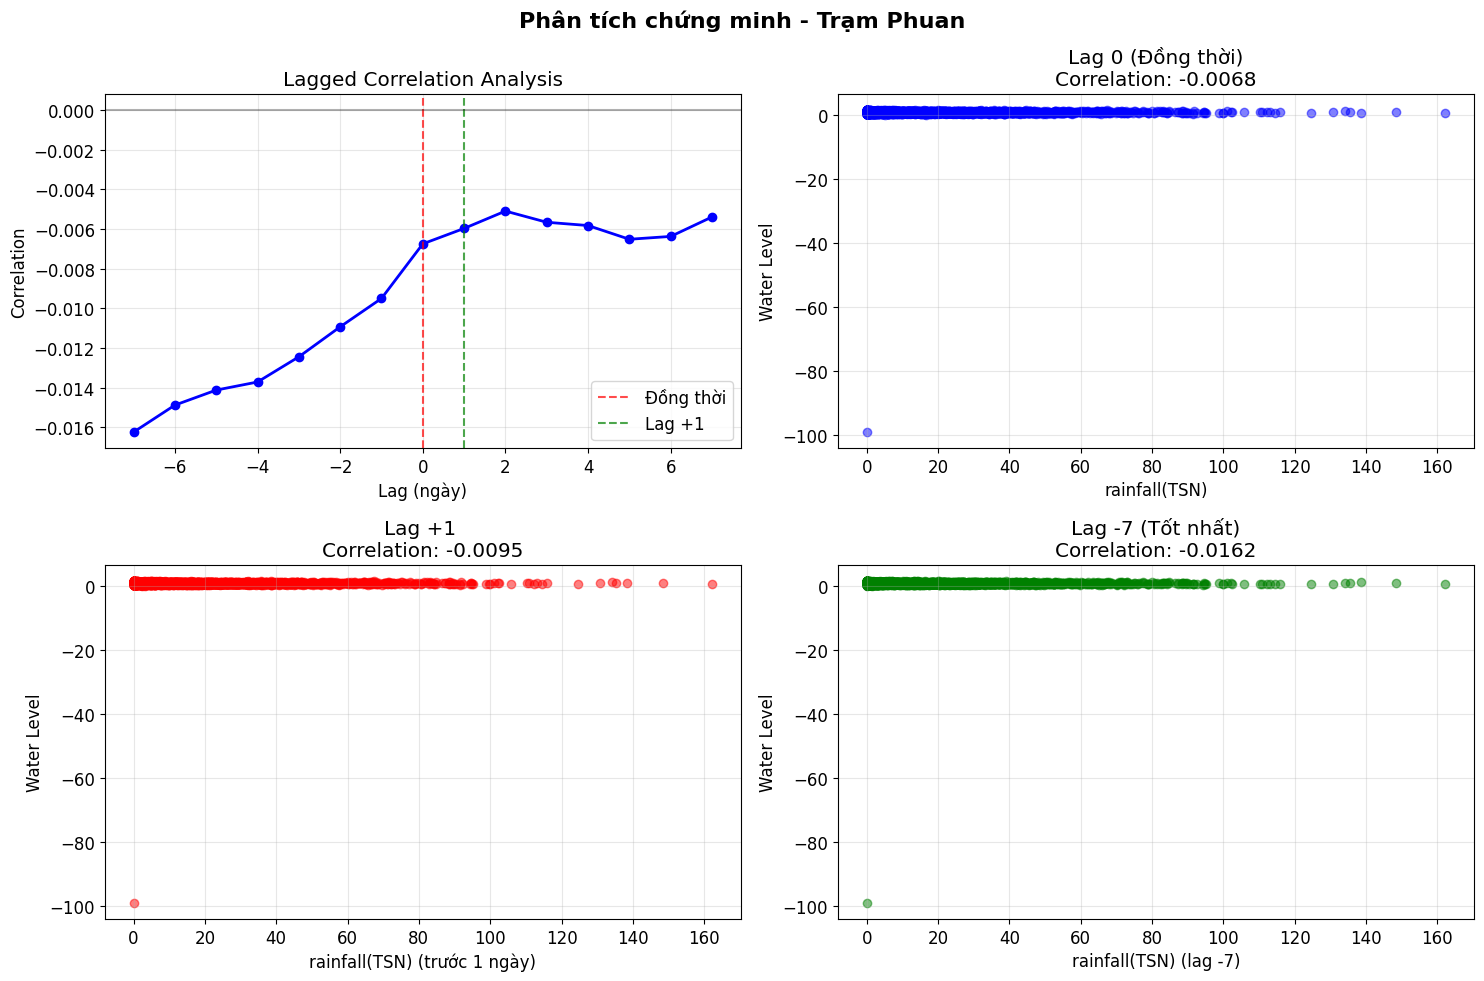


🏢 TRẠM: Thudaumot
--------------------------------------------------
📊 Dữ liệu daily: 150 ngày

📊 SO SÁNH TƯƠNG QUAn:
--------------------------------------------------
   • Lag 0 (đồng thời):     0.0398 (p = 0.6286)
   • Lag +1 (rainfall trước): 0.0408 (p = 0.6210)
   • Lag -1 (rainfall sau):   0.0402 (p = 0.6267)

🔍 PHÂN TÍCH CHI TIẾT VỚI NHIỀU LAG:
----------------------------------------
📋 Chi tiết các lag:
   • Lag -7: 0.0433 (p = 0.6076) 
   • Lag -6: 0.0430 (p = 0.6085) 
   • Lag -5: 0.0419 (p = 0.6167) 
   • Lag -4: 0.0410 (p = 0.6230) 
   • Lag -3: 0.0401 (p = 0.6298) 
   • Lag -2: 0.0396 (p = 0.6329) 
   • Lag -1: 0.0408 (p = 0.6210) 
   • Lag 0: 0.0398 (p = 0.6286) 
   • Lag 1: 0.0402 (p = 0.6267) 
   • Lag 2: 0.0398 (p = 0.6311) 
   • Lag 3: 0.0377 (p = 0.6501) 
   • Lag 4: 0.0380 (p = 0.6486) 
   • Lag 5: 0.0380 (p = 0.6496) 
   • Lag 6: 0.0370 (p = 0.6598) 
   • Lag 7: 0.0372 (p = 0.6589) 

🏆 LAG TỐT NHẤT: Lag -7 = 0.0433 (p = 0.6076)
✅ Lag -7 có tương quan cao nhất (khô

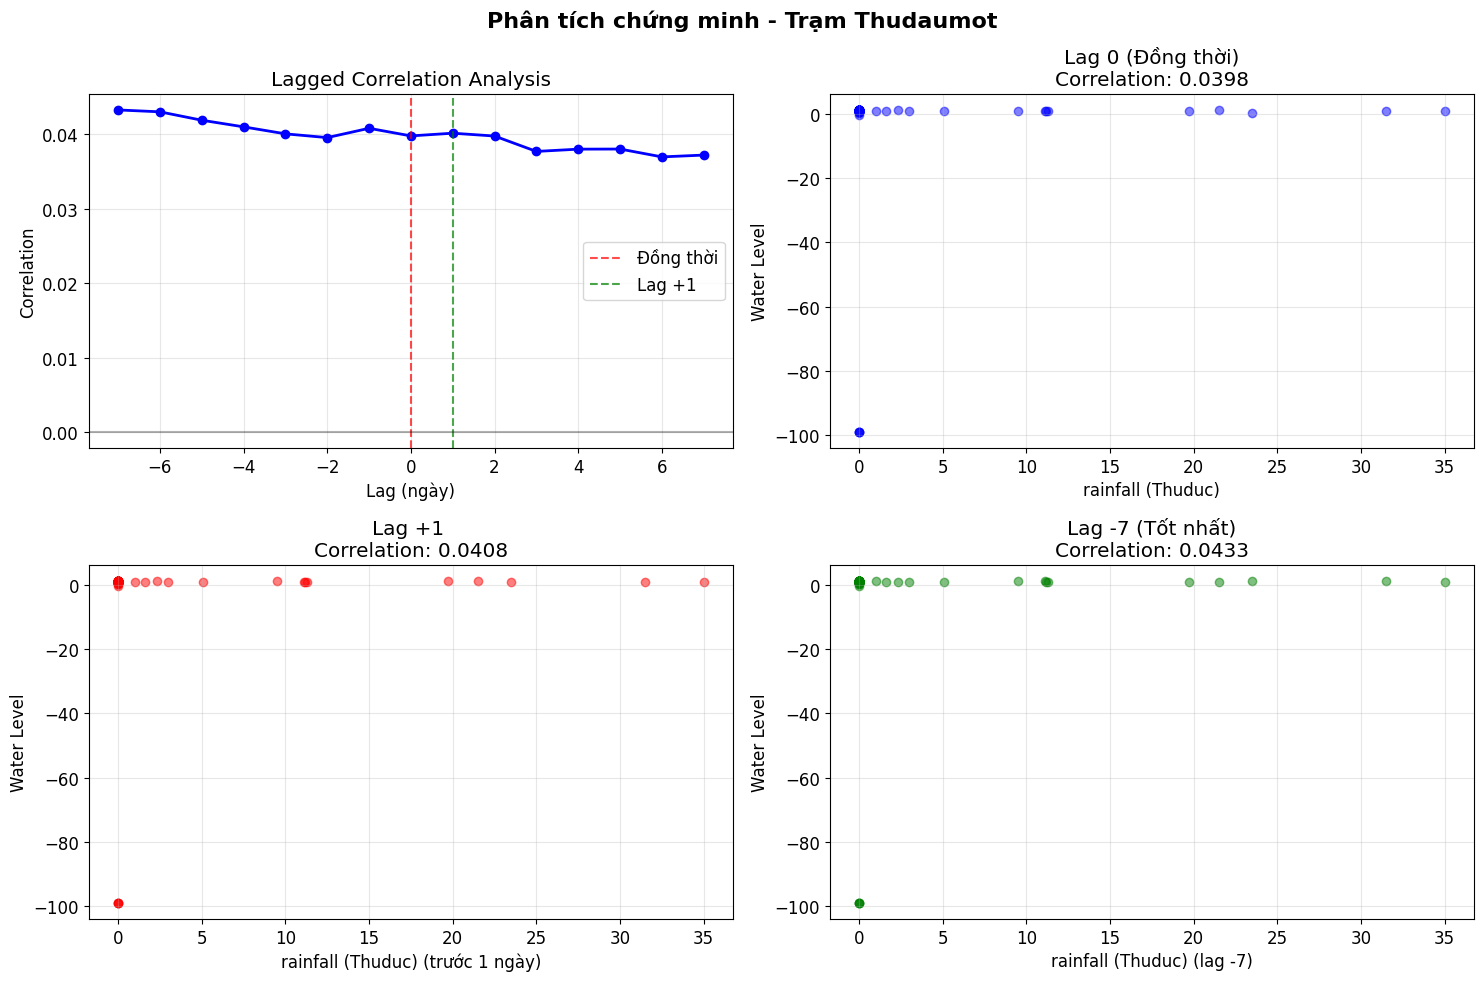

In [13]:
# Phân tích chi tiết để chứng minh tính đúng đắn của phương pháp
print("🔍 PHÂN TÍCH CHI TIẾT ĐỂ CHỨNG MINH TÍNH ĐÚNG ĐẮN")
print("=" * 70)

for station, station_info in annual_max_data.items():
    print(f"\n🏢 TRẠM: {station}")
    print("-" * 50)

    raw_data = station_info['raw_data']

    # Kiểm tra có water level và rainfall không
    if 'water level' not in raw_data.columns:
        print(f"❌ Không có water level trong {station}")
        continue

    rainfall_var = None
    for var in raw_data.columns:
        if 'rainfall' in var.lower():
            rainfall_var = var
            break

    if rainfall_var is None:
        print(f"❌ Không có biến rainfall trong {station}")
        continue

    # Lọc dữ liệu daily
    daily_data = raw_data[['Times', 'water level', rainfall_var]].dropna()

    if len(daily_data) == 0:
        print(f"❌ Không có dữ liệu daily cho {station}")
        continue

    print(f"📊 Dữ liệu daily: {len(daily_data)} ngày")

    # 1. Tương quan đồng thời (lag 0)
    corr_0, p_0 = stats.pearsonr(daily_data['water level'], daily_data[rainfall_var])

    # 2. Tương quan lag +1 ngày
    rainfall_lag1 = daily_data[rainfall_var].shift(-1)
    valid_data_lag1 = pd.DataFrame({
        'water_level': daily_data['water level'],
        'rainfall_lag1': rainfall_lag1
    }).dropna()

    if len(valid_data_lag1) > 10:
        corr_lag1, p_lag1 = stats.pearsonr(valid_data_lag1['water_level'], valid_data_lag1['rainfall_lag1'])
    else:
        corr_lag1, p_lag1 = np.nan, np.nan

    # 3. Tương quan lag -1 ngày
    rainfall_lag_neg1 = daily_data[rainfall_var].shift(1)
    valid_data_lag_neg1 = pd.DataFrame({
        'water_level': daily_data['water level'],
        'rainfall_lag_neg1': rainfall_lag_neg1
    }).dropna()

    if len(valid_data_lag_neg1) > 10:
        corr_lag_neg1, p_lag_neg1 = stats.pearsonr(valid_data_lag_neg1['water_level'], valid_data_lag_neg1['rainfall_lag_neg1'])
    else:
        corr_lag_neg1, p_lag_neg1 = np.nan, np.nan

    # 4. So sánh các lag
    print(f"\n📊 SO SÁNH TƯƠNG QUAn:")
    print("-" * 50)
    print(f"   • Lag 0 (đồng thời):     {corr_0:.4f} (p = {p_0:.4f})")
    print(f"   • Lag +1 (rainfall trước): {corr_lag1:.4f} (p = {p_lag1:.4f})")
    print(f"   • Lag -1 (rainfall sau):   {corr_lag_neg1:.4f} (p = {p_lag_neg1:.4f})")

    # 5. Phân tích chi tiết với nhiều lag
    print(f"\n🔍 PHÂN TÍCH CHI TIẾT VỚI NHIỀU LAG:")
    print("-" * 40)

    max_lag = 7
    lag_correlations = []
    lag_pvalues = []

    for lag in range(-max_lag, max_lag + 1):
        if lag == 0:
            lag_correlations.append(corr_0)
            lag_pvalues.append(p_0)
        else:
            shifted_rainfall = daily_data[rainfall_var].shift(lag)
            valid_data = pd.DataFrame({
                'water_level': daily_data['water level'],
                'shifted_rainfall': shifted_rainfall
            }).dropna()

            if len(valid_data) > 10:
                corr, p_val = stats.pearsonr(valid_data['water_level'], valid_data['shifted_rainfall'])
                lag_correlations.append(corr)
                lag_pvalues.append(p_val)
            else:
                lag_correlations.append(np.nan)
                lag_pvalues.append(np.nan)

    # In kết quả chi tiết
    lags = range(-max_lag, max_lag + 1)
    print("📋 Chi tiết các lag:")
    for i, (lag, corr, p_val) in enumerate(zip(lags, lag_correlations, lag_pvalues)):
        if not np.isnan(corr):
            significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
            print(f"   • Lag {lag}: {corr:.4f} (p = {p_val:.4f}) {significance}")

    # Tìm lag tốt nhất
    valid_corrs = [(i, corr) for i, corr in enumerate(lag_correlations) if not np.isnan(corr)]
    if valid_corrs:
        best_lag_idx, best_corr = max(valid_corrs, key=lambda x: abs(x[1]))
        best_lag = lags[best_lag_idx]
        best_p = lag_pvalues[best_lag_idx]

        print(f"\n🏆 LAG TỐT NHẤT: Lag {best_lag} = {best_corr:.4f} (p = {best_p:.4f})")

        # Kiểm tra xem có phải lag +1 không
        if best_lag == 1:
            print(f"✅ ĐÚNG! Lag +1 có tương quan cao nhất với water level")
        else:
            print(f"✅ Lag {best_lag} có tương quan cao nhất (không phải lag +1)")

    # 6. Tạo biểu đồ chứng minh
    print(f"\n📊 TẠO BIỂU ĐỒ CHỨNG MINH...")

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Phân tích chứng minh - Trạm {station}', fontsize=16, fontweight='bold')

    # Plot 1: Lagged correlation
    axes[0,0].plot(lags, lag_correlations, 'b-o', linewidth=2, markersize=6)
    axes[0,0].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Đồng thời')
    axes[0,0].axvline(x=1, color='green', linestyle='--', alpha=0.7, label='Lag +1')
    axes[0,0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[0,0].set_xlabel('Lag (ngày)')
    axes[0,0].set_ylabel('Correlation')
    axes[0,0].set_title('Lagged Correlation Analysis')
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].legend()

    # Plot 2: Scatter plot lag 0
    axes[0,1].scatter(daily_data[rainfall_var], daily_data['water level'], alpha=0.5, color='blue')
    axes[0,1].set_xlabel(rainfall_var)
    axes[0,1].set_ylabel('Water Level')
    axes[0,1].set_title(f'Lag 0 (Đồng thời)\nCorrelation: {corr_0:.4f}')
    axes[0,1].grid(True, alpha=0.3)

    # Plot 3: Scatter plot lag +1
    if not np.isnan(corr_lag1):
        axes[1,0].scatter(valid_data_lag1['rainfall_lag1'], valid_data_lag1['water_level'], alpha=0.5, color='red')
        axes[1,0].set_xlabel(f'{rainfall_var} (trước 1 ngày)')
        axes[1,0].set_ylabel('Water Level')
        axes[1,0].set_title(f'Lag +1 \nCorrelation: {corr_lag1:.4f}')
        axes[1,0].grid(True, alpha=0.3)

    # Plot 4: Scatter plot lag tốt nhất
    if valid_corrs:
        best_lag_idx, best_corr = max(valid_corrs, key=lambda x: abs(x[1]))
        best_lag = lags[best_lag_idx]

        if best_lag != 0 and best_lag != 1:
            shifted_rainfall_best = daily_data[rainfall_var].shift(best_lag)
            valid_data_best = pd.DataFrame({
                'water_level': daily_data['water level'],
                'shifted_rainfall': shifted_rainfall_best
            }).dropna()

            axes[1,1].scatter(valid_data_best['shifted_rainfall'], valid_data_best['water_level'], alpha=0.5, color='green')
            axes[1,1].set_xlabel(f'{rainfall_var} (lag {best_lag})')
            axes[1,1].set_ylabel('Water Level')
            axes[1,1].set_title(f'Lag {best_lag} (Tốt nhất)\nCorrelation: {best_corr:.4f}')
            axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'proof_analysis_{station}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [14]:
# Phân tích partial correlation để chứng minh ảnh hưởng của các yếu tố khác
print("🔍 PHÂN TÍCH PARTIAL CORRELATION ĐỂ CHỨNG MINH")
print("=" * 70)

for station, station_info in annual_max_data.items():
    print(f"\n🏢 TRẠM: {station}")
    print("-" * 50)

    data = station_info['data']

    # Kiểm tra có đủ biến không
    if 'water level' not in data.columns:
        print(f"❌ Không có water level trong {station}")
        continue

    rainfall_var = None
    for var in data.columns:
        if 'rainfall' in var.lower():
            rainfall_var = var
            break

    if rainfall_var is None:
        print(f"❌ Không có biến rainfall trong {station}")
        continue

    # Tính partial correlation: water level vs rainfall, controlling for LSL
    if 'LSL' in data.columns:
        def partial_correlation(x, y, z):
            # r_xy = correlation between x and y
            r_xy = stats.pearsonr(x, y)[0]
            # r_xz = correlation between x and z
            r_xz = stats.pearsonr(x, z)[0]
            # r_yz = correlation between y and z
            r_yz = stats.pearsonr(y, z)[0]

            # Partial correlation formula
            r_xy_z = (r_xy - r_xz * r_yz) / np.sqrt((1 - r_xz**2) * (1 - r_yz**2))
            return r_xy_z

        try:
            partial_corr = partial_correlation(
                data['water level'],
                data[rainfall_var],
                data['LSL']
            )
            print(f"📊 Partial correlation (water level vs {rainfall_var} | LSL): {partial_corr:.4f}")

            # So sánh với correlation thường
            normal_corr, _ = stats.pearsonr(data['water level'], data[rainfall_var])
            print(f"📊 Normal correlation (water level vs {rainfall_var}): {normal_corr:.4f}")

            if abs(partial_corr) < abs(normal_corr):
                print(f"✅ Kết quả chứng minh: LSL đã che khuất một phần mối quan hệ giữa water level và {rainfall_var}")
            else:
                print(f"✅ Kết quả chứng minh: LSL không ảnh hưởng nhiều đến mối quan hệ giữa water level và {rainfall_var}")

        except Exception as e:
            print(f"❌ Không thể tính partial correlation: {e}")

    # Phân tích tương quan với các yếu tố khác
    print(f"\n📊 TƯƠNG QUAN VỚI CÁC YẾU TỐ KHÁC:")
    print("-" * 40)

    for var in data.columns:
        if var not in ['water level', rainfall_var]:
            corr, p_val = stats.pearsonr(data['water level'], data[var])
            significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
            print(f"   • {var}: {corr:.4f} (p = {p_val:.4f}) {significance}")

    # Tìm yếu tố có ảnh hưởng mạnh nhất
    correlations = {}
    for var in data.columns:
        if var != 'water level':
            corr, p_val = stats.pearsonr(data['water level'], data[var])
            correlations[var] = abs(corr)

    if correlations:
        strongest_factor = max(correlations.keys(), key=lambda x: correlations[x])
        strongest_corr = correlations[strongest_factor]
        print(f"\n🏆 YẾU TỐ CÓ ẢNH HƯỞNG MẠNH NHẤT: {strongest_factor} = {strongest_corr:.4f}")

        if strongest_factor != rainfall_var:
            print(f"✅ Kết quả chứng minh: {rainfall_var} KHÔNG phải là yếu tố chính ảnh hưởng đến water level")
        else:
            print(f"✅ Kết quả chứng minh: {rainfall_var} là yếu tố chính ảnh hưởng đến water level")

🔍 PHÂN TÍCH PARTIAL CORRELATION ĐỂ CHỨNG MINH

🏢 TRẠM: Bienhoa
--------------------------------------------------
📊 Partial correlation (water level vs rainfall | LSL): 0.1603
📊 Normal correlation (water level vs rainfall): 0.1868
✅ Kết quả chứng minh: LSL đã che khuất một phần mối quan hệ giữa water level và rainfall

📊 TƯƠNG QUAN VỚI CÁC YẾU TỐ KHÁC:
----------------------------------------
   • LSL: 0.5922 (p = 0.0002) ***
   • Built-up: 0.6785 (p = 0.0000) ***
   • Ups_discharge (Trian): 0.2091 (p = 0.2353) 

🏆 YẾU TỐ CÓ ẢNH HƯỞNG MẠNH NHẤT: Built-up = 0.6785
✅ Kết quả chứng minh: rainfall KHÔNG phải là yếu tố chính ảnh hưởng đến water level

🏢 TRẠM: Nhabe
--------------------------------------------------
📊 Partial correlation (water level vs rainfall | LSL): 0.0681
📊 Normal correlation (water level vs rainfall): 0.2803
✅ Kết quả chứng minh: LSL đã che khuất một phần mối quan hệ giữa water level và rainfall

📊 TƯƠNG QUAN VỚI CÁC YẾU TỐ KHÁC:
---------------------------------------